In [445]:
!pip install stargazer

In [9]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
from datetime import datetime
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from linearmodels.panel import PanelOLS
from stargazer.stargazer import Stargazer
import statsmodels.api as sm


def dps_all_f(city,entity,start_date, end_date):

    query = """
    with details as (
    SELECT   smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date
            ,date_trunc(created_date, ISOWEEK) week
            ,date_trunc(created_date, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    join
    (   SELECT  o.customer_account_id
        FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
        WHERE o.entity_id = \"""" + entity + """\"
            AND (o.customer_first_order_date is null
            OR date(o.customer_first_order_date) = '0001-01-01')
            AND o.city_name in (""" + city + """)
            group by 1
    ) tm on tm.customer_account_id = smto.customer_account_id
    WHERE smto.created_date BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    AND city_name in (""" + city + """)
    AND is_own_delivery = TRUE
    AND is_sent = TRUE
    ),
    voucher_data as (
    SELECT  o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
            ,(case when vouchers[SAFE_OFFSET(0)].voucher_code not in ('nyburgare', 'mumsigt','megagott','mums150') or
            vouchers[SAFE_OFFSET(0)].voucher_code not in ('mieletön', 'tajuton','uskomaton','arena','huikea') or 
            vouchers[SAFE_OFFSET(0)].voucher_code not like 'mieletön%' or 
            vouchers[SAFE_OFFSET(0)].voucher_code not like 'tajuton%' then vouchers[SAFE_OFFSET(0)].amount_eur else 0 end) voucher_amount_nc_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id = \"""" + entity + """\"
    AND partition_date_local BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    )
    select d.*
           ,vd.voucher_amount_eur
           ,voucher_amount_nc_eur
    from details d 
    left join voucher_data vd on vd.global_entity_id = d.entity_id and vd.order_id = d.platform_order_code
    """

    return query


def sessions(entity, city, start_date, end_date):

    query = """
    SELECT
        entity_id,
        date_trunc(created_date, MONTH) month,
        date_trunc(created_date, ISOWEEK) week,
        created_date,
        count(distinct perseus_session_key) total_sessions,
        count(distinct sessions.perseus_client_id) total_users,
        count(distinct case when has_transaction = True then sessions.perseus_client_id else null end) total_orders,
        count(distinct case when has_transaction = True then sessions.perseus_client_id else null end) / count(distinct perseus_session_key)   
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
    WHERE created_date BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    AND entity_id = \"""" + entity + """\" 
    and dps_zone[SAFE_OFFSET(0)].city_name in (""" + city + """)
    group  by 1,2,3,4
    """
    
    return query

def analyze_city_orders(df, df1, period):
    
    df['entity_id_period'] = df['entity_id'] + '_' + period
    df1['entity_id_period'] = df['entity_id'] + '_' + period
        
    grouped_data_post = df.groupby('entity_id_period').agg({
        'platform_order_code': 'nunique',
        'customer_account_id': 'nunique',
        'gfv_eur': 'sum',
        'voucher_amount_eur': 'sum',
        'fully_loaded_gross_profit_eur': 'sum',
        'foregone_delivery_fee': 'sum'
    }).reset_index()

    grouped_data_post.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_data_post.columns]

    grouped_data_post = grouped_data_post.rename(columns={
        'platform_order_code': 'Orders',
        'customer_account_id': 'Acquistions',
        'voucher_amount_eur': 'Voucher_cost_eur',
        'gfv_eur':'gfv_eur',
        'fully_loaded_gross_profit_eur' : 'FLGP_eur',
        'foregone_delivery_fee': 'FDNC_cost_eur',
        })
    
    session_data_post = df1.groupby('entity_id_period').agg({
        'total_sessions': 'sum',
    }).reset_index()

    grouped_data_post = grouped_data_post.merge(session_data_post, on='entity_id_period', how='left').fillna(0)

    voucher_counts = df[(df['voucher_amount_eur'] > 0) & ((df['dps_delivery_fee_eur'] == 0) | (df['dps_delivery_fee_eur'].isna()))].groupby('entity_id_period')['platform_order_code'].nunique().reset_index()
    voucher_counts = voucher_counts.rename(columns={'platform_order_code': 'Stacked_orders'})

    grouped_data_post = grouped_data_post.merge(voucher_counts, on='entity_id_period', how='left').fillna(0)
    grouped_data_post[['gfv_eur','Voucher_cost_eur','FLGP_eur','FDNC_cost_eur']] = grouped_data_post[['gfv_eur','Voucher_cost_eur','FLGP_eur','FDNC_cost_eur']].astype(int)

    grouped_data_post['total_acquistion_cost'] = grouped_data_post['FDNC_cost_eur'] + grouped_data_post['Voucher_cost_eur']

    grouped_data_post = grouped_data_post[['entity_id_period','total_sessions','Orders','Stacked_orders','Acquistions','FDNC_cost_eur','Voucher_cost_eur','total_acquistion_cost','gfv_eur','FLGP_eur']]

    return grouped_data_post.round(0).set_index('entity_id_period').T

def cities_summary(pre_df, pre_sessions, post_df, post_sessions):
    
    df2 = analyze_city_orders(pre_df, pre_sessions, 'pre')
    df1 = analyze_city_orders(post_df,post_sessions, 'post')

    merged_df = pd.merge(df2, df1, left_index=True, right_index=True, how='outer')

    for col in merged_df.columns:
        if col.endswith('_post'):
            post = col
            pre = post.replace('_post', '_pre')  # Find the corresponding _pre column
            
            if pre in merged_df.columns:  # Ensure the _pre column exists
                # Calculate percentage change and store it in 'percentage_change'
                merged_df['percentage_change'] = round(
                    ((merged_df[post] - merged_df[pre]) / abs(merged_df[pre])) * 100, 0
                )
    
    return merged_df

def user_retention_wow(df):

    post_inter_df = df.copy()

    post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')
    post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

    total_users = post_inter_df['customer_account_id'].nunique()

    retention_df = post_inter_df.groupby('week_diff').agg(
        users_retained=('customer_account_id', 'nunique')
    ).reset_index()

    retention_df['wow_retention'] = round((retention_df['users_retained'] / retention_df['users_retained'][0]) * 100,2)
    
    return retention_df


def add_foregone_delivery_fee(df):
    
    # Create the 'foregone_delivery_fee' column
    df['foregone_delivery_fee'] = np.where(
        (df['dps_delivery_fee_eur'] == 0) | (df['dps_delivery_fee_eur'].isnull()), 
        df['dps_standard_fee_eur'], 
        0
    )
    
    # Create the 'foregone_delivery_fee_final' column
    df['foregone_delivery_fee_final'] = df.loc[
        (df['has_new_customer_condition'] == False) & (df['new_customer_condition_type'] != 'TOTAL'),
        'foregone_delivery_fee'
    ]
    
    return df

def create_regression_df(post_treatment, pre_treatment, post_s_treatment, pre_s_treatment, post_control, pre_control, post_s_control, pre_s_control, agg_metrics, aggregation):
    
    # Aggregate post-treatment data
    a = post_treatment.groupby([aggregation]).agg(agg_metrics).reset_index()
    a_s = post_s_treatment.groupby([aggregation]).agg({'total_sessions': 'sum'}).reset_index()
    a = a.merge(a_s, on=aggregation, how='left')
    a[a.select_dtypes(include=['number']).columns] = a.select_dtypes(include=['number']).fillna(0)
    
    # Aggregate pre-treatment data
    b = pre_treatment.groupby([aggregation]).agg(agg_metrics).reset_index()
    b_s = pre_s_treatment.groupby([aggregation]).agg({'total_sessions': 'sum'}).reset_index()
    b = b.merge(b_s, on=aggregation, how='left')
    b[b.select_dtypes(include=['number']).columns] = b.select_dtypes(include=['number']).fillna(0)

    # Aggregate post-control data
    c = post_control.groupby([aggregation]).agg(agg_metrics).reset_index()
    c_s = post_s_control.groupby([aggregation]).agg({'total_sessions': 'sum'}).reset_index()
    c = c.merge(c_s, on=aggregation, how='left')
    c[c.select_dtypes(include=['number']).columns] = c.select_dtypes(include=['number']).fillna(0)

    # Aggregate pre-control data
    d = pre_control.groupby([aggregation]).agg(agg_metrics).reset_index()
    d_s = pre_s_control.groupby([aggregation]).agg({'total_sessions': 'sum'}).reset_index()
    d = d.merge(d_s, on=aggregation, how='left')
    d[d.select_dtypes(include=['number']).columns] = d.select_dtypes(include=['number']).fillna(0)

    # Combine treatment data
    combined_treatment = pd.concat([a, b])
    combined_treatment['group'] = 'treatment'

    # Combine control data
    combined_control = pd.concat([c, d])
    combined_control['group'] = 'control'

    # Combine treatment and control data
    final_df = pd.concat([combined_treatment, combined_control])
    
    # Convert 'foregone_delivery_fee_final' and 'voucher_amount_nc_eur' to float before summing
    final_df['foregone_delivery_fee_final'] = final_df['foregone_delivery_fee_final'].astype(float)
    final_df['voucher_amount_nc_eur'] = final_df['voucher_amount_nc_eur'].astype(float)

    # Calculate total cost
    final_df['total_cost'] = final_df['foregone_delivery_fee_final'] + final_df['voucher_amount_nc_eur']

    # Calculate average metrics per order
    final_df['orders_per_user'] = final_df['platform_order_code'] / final_df['customer_account_id']
    final_df['flgpo'] = final_df['fully_loaded_gross_profit_eur'] / final_df['platform_order_code']
    final_df['cost_per_order'] = final_df['total_cost'] / final_df['platform_order_code']
    final_df['session_to_order'] = final_df['total_sessions'] / final_df['platform_order_code']

    return final_df

def plot_metric_trends(df, x_col, y_col, intervention_date):
    
    # Convert treatment date string to datetime
    treatment_date = pd.to_datetime(intervention_date)

    # Define colors for the groups
    palette = {'treatment': 'red', 'control': 'grey'}
    
    # Create the plot
    plt.figure(figsize=(18, 8))
    sns.lineplot(data=df, x=x_col, y=y_col, hue='group', palette = palette)
    
    # Add vertical line for treatment date
    plt.axvline(x=treatment_date, color='black', linestyle='--', label='Treatment Date')
    
    # Add legend and show plot
    plt.legend()
    plt.show()


def plot_did(df, intervention_date, metric, aggregation):
    # Ensure the week column is in datetime format
    df[aggregation] = pd.to_datetime(df[aggregation], errors='coerce')

    # Ensure metric column is numeric
    df[metric] = pd.to_numeric(df[metric], errors='coerce')

    # Drop rows with missing values in either column
    df_clean = df.dropna(subset=[aggregation, metric])

    # Convert metric column to numeric types
    df_clean[metric] = df_clean[metric].astype(float)

    # Separate control and treatment groups
    control_group = df_clean[df_clean['group'] == 'control'].copy()
    treatment_group = df_clean[df_clean['group'] == 'treatment'].copy()

    # Split control and treatment groups into pre- and post-intervention
    control_pre = control_group[control_group[aggregation] < intervention_date]
    control_post = control_group[control_group[aggregation] >= intervention_date]
    treatment_pre = treatment_group[treatment_group[aggregation] < intervention_date]
    treatment_post = treatment_group[treatment_group[aggregation] >= intervention_date]

    # Convert datetime to numeric (days from minimum date) for regression purposes
    treatment_pre['date_numeric'] = (treatment_pre[aggregation] - treatment_pre[aggregation].min()).dt.days
    treatment_post['date_numeric'] = (treatment_post[aggregation] - treatment_pre[aggregation].min()).dt.days

    # Linear regression model for pre-intervention data
    model_pre = LinearRegression()
    X_pre = treatment_pre[['date_numeric']]
    y_pre = treatment_pre[metric]
    model_pre.fit(X_pre, y_pre)

    # Predict values for the pre-intervention period to plot the line
    treatment_pre['predicted_pre'] = model_pre.predict(treatment_pre[['date_numeric']])

    # Predict values for the post-intervention period using the pre-intervention model to ensure continuity
    treatment_post['predicted_pre'] = model_pre.predict(treatment_post[['date_numeric']])

    # Linear regression model for post-intervention data (separate model)
    model_post = LinearRegression()
    X_post = treatment_post[['date_numeric']]
    y_post = treatment_post[metric]
    model_post.fit(X_post, y_post)

    # Predict values for the post-intervention period using the post-intervention model
    treatment_post['predicted_post'] = model_post.predict(treatment_post[['date_numeric']])

    # Combine pre- and post-intervention predictions for the green line
    treatment_combined = pd.concat([treatment_pre[[aggregation, 'predicted_pre']],
                                    treatment_post[[aggregation, 'predicted_pre']]])

    # Scatter plot for the control group pre-intervention with regression line (extended for post-intervention)
    fig = px.scatter(
        control_group,
        x=aggregation,
        y=metric,
        trendline='ols',  # Regression line for entire control group
        trendline_scope='overall',  # Apply regression to the entire control group
        color_discrete_sequence=['blue'],  # Control group in blue
    )

    # Plot scatter for post-intervention control data only
    fig.add_trace(
        px.scatter(
            control_post,
            x=aggregation,
            y=metric,
            color_discrete_sequence=['blue'],  # Post-intervention control in light blue
        ).data[0]  # Add only the scatter trace (no regression line for post)
    )

    # Scatter plot for the treatment group pre-intervention
    fig.add_trace(
        px.scatter(
            treatment_pre,
            x=aggregation,
            y=metric,
            color_discrete_sequence=['green'],  # Pre-intervention treatment in green
        ).data[0]  # Add scatter trace for pre-intervention
    )

    # Add continuous pre-intervention regression line (green) spanning both periods
    fig.add_trace(
        px.line(
            treatment_combined,
            x=aggregation,
            y='predicted_pre',
            color_discrete_sequence=['green'],  # Pre-intervention and post-intervention line in green
        ).data[0]  # Add continuous line trace for pre- and post-intervention predicted values
    )

    # Scatter plot for post-intervention treatment data
    fig.add_trace(
        px.scatter(
            treatment_post,
            x=aggregation,
            y=metric,
            color_discrete_sequence=['red'],  # Post-intervention treatment in red
        ).data[0]  # Add scatter trace for post-intervention
    )

    # Add post-intervention regression line (red)
    fig.add_trace(
        px.line(
            treatment_post,
            x=aggregation,
            y='predicted_post',
            color_discrete_sequence=['red'],  # Post-intervention line in red
        ).data[0]  # Add line trace for post-intervention regression
    )

    # Update layout for better visualization
    fig.update_layout(
        xaxis_title='Created Date',
        yaxis_title=metric,
        yaxis_range=[0, None],  # Start y-axis at 0
        legend_title='Group',
        height=400,  # Height of the plot
        width=800,  # Width of the plot
        showlegend=False  # Hide duplicate legends from added traces
    )

    # Add a vertical dotted line at the intervention date
    fig.add_shape(
        type="line",
        x0=intervention_date,
        y0=0,
        x1=intervention_date,
        y1=df[metric].max(),  # Set the y1 to the max value of metric
        line=dict(
            color="Black",
            width=2,
            dash="dot",  # Dotted line
        ),
    )

    # Add annotation to label the intervention date
    fig.add_annotation(
        x=intervention_date,
        y=df[metric].max(),
        text="Intervention Date",
        showarrow=False,
        yshift=10,
    )

    # Adding annotations for the green, red, and blue lines
    # Green line annotation
    fig.add_annotation(
        x=treatment_pre[aggregation].min(),  # Start of the green line
        y=treatment_pre['predicted_pre'].max(),
        text="Treatment Pre-Intervention",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(color="green")
    )

    # Red line annotation
    fig.add_annotation(
        x=treatment_post[aggregation].max(),  # End of the red line
        y=treatment_post['predicted_post'].max(),
        text="Treatment Post-Intervention",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(color="red")
    )

    # Blue line annotation (Control group regression line)
    fig.add_annotation(
        x=control_group[aggregation].min(),  # Start of the control line
        y=control_group[metric].mean(),  # Roughly place it near the mean
        text="Control Group",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(color="blue")
    )

    # Show the plot with the vertical line
    fig.show()


def run_panel_ols_with_trend_diff(df, y_var, agg_col, intervention_date_str):
    # Convert intervention_date to datetime
    intervention_date = pd.to_datetime(intervention_date_str, format='%Y-%m-%d')

    # Convert week column to datetime
    df[agg_col] = pd.to_datetime(df[agg_col], errors='coerce')

    # Creating flags for treatment and post-intervention period
    df['variant_cities'] = df['group'] == 'treatment'
    df['after'] = df[agg_col] >= intervention_date
    df['treated'] = 1 * (df['variant_cities'] & df['after'])

    # Create a numeric version of the week column for trend estimation
    df['week_numeric'] = (df[agg_col] - df[agg_col].min()).dt.days / 7

    # Create a flag for the pre-intervention period to specifically capture differences in trends before the intervention
    df['pre_intervention'] = df[agg_col] < intervention_date

    # Interaction term between pre-intervention time trend and treatment group
    df['pre_trend_diff'] = df['variant_cities'] * df['week_numeric'] * df['pre_intervention']

    # Set 'group' and 'week' as a multi-level index for PanelOLS
    df = df.set_index(['group', agg_col])

    # Define and fit the PanelOLS model, adding the pre-intervention trend interaction
    formula = f'{y_var} ~ treated + pre_trend_diff + EntityEffects + TimeEffects'
    model = PanelOLS.from_formula(formula, data=df)

    # Fit the model with clustered standard errors (no entity-level clustering)
    results = model.fit(cov_type='clustered', cluster_entity=False)

    return results
  

def run_panel_ols_with_trend_diff_plotting(df, y_var, agg_col, intervention_date_str):
    # Convert intervention_date to datetime
    intervention_date = pd.to_datetime(intervention_date_str, format='%Y-%m-%d')

    # Convert week column to datetime
    df[agg_col] = pd.to_datetime(df[agg_col], errors='coerce')

    # Creating flags for treatment and post-intervention period
    df['variant_cities'] = df['group'] == 'treatment'
    df['after'] = df[agg_col] >= intervention_date
    df['treated'] = 1 * (df['variant_cities'] & df['after'])

    # Create a numeric version of the week column for trend estimation
    df['week_numeric'] = (df[agg_col] - df[agg_col].min()).dt.days / 7

    # Create a flag for the pre-intervention period to specifically capture differences in trends before the intervention
    df['pre_intervention'] = df[agg_col] < intervention_date

    # Interaction term between pre-intervention time trend and treatment group
    df['pre_trend_diff'] = df['variant_cities'] * df['week_numeric'] * df['pre_intervention']

    # Set 'group' and 'week' as a multi-level index for PanelOLS
    df = df.set_index(['group', agg_col])

    # Define and fit the PanelOLS model, adding the pre-intervention trend interaction
    formula = f'{y_var} ~ treated + pre_trend_diff + EntityEffects + TimeEffects'
    model = PanelOLS.from_formula(formula, data=df)

    # Fitting the model
    results = model.fit(cov_type='clustered', cluster_entity=False)

    # Extracting coefficient, confidence intervals
    coef = results.params['treated']
    ci_low, ci_high = results.conf_int().loc['treated']

    # Calculating baseline mean in the treatment group before the intervention
    baseline_mean = df.loc[
        (df['variant_cities'] == True) & (df['after'] == False), y_var
    ].mean()

    # Calculating percentage change
    percentage_change = (coef / baseline_mean) * 100
    ci_low_pct = (ci_low / baseline_mean) * 100
    ci_high_pct = (ci_high / baseline_mean) * 100

    return {
        'y_var': y_var,
        'coef': coef,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'percentage_change': percentage_change,
        'ci_low_pct': ci_low_pct,
        'ci_high_pct': ci_high_pct
    }

# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)



/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [11]:
entity_id = 'OP_SE'

## Treatment Cities ##
city_treatment = ('Uppsala','Vasteras','Orebro','Stockholm')
city_str_treatment = ",".join([f"'{c}'" for c in city_treatment])

## Control Cities  ##
city_control = ('Umea','Malmo')
city_str_control = ",".join([f"'{c}'" for c in city_control])

### post time period ###
start_date_post = '2024-08-06'
end_date_post = '2024-09-25'

print(f'start date of post treatment: {start_date_post}')
print(f'end date of post treatment: {end_date_post}')


### pre time period ###

## start date pre control calcualtion ##

#convert string date to date format#
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

#calculate the difference in days between start and end date#
days_difference = (end_date - start_date).days
days_difference

print(f'Difference in days between start and end date of post treatment: {days_difference}')

# Subtract the number of days from start date to get start date of pre treatment period#
new_start_datetime = start_date - timedelta(days=days_difference)
new_start_date = new_start_datetime.date()
new_start_date = new_start_date.strftime("%Y-%m-%d")
start_date_pre = new_start_date

## end date pre treatment calcualtion ##

tmp_datetime = datetime.strptime(start_date_post, '%Y-%m-%d')
new_end_datetime = tmp_datetime - timedelta(days=1)
new_end_date = new_end_datetime.strftime('%Y-%m-%d')
end_date_pre = new_end_date

print(f'start date of pre treatment: {start_date_pre}')
print(f'end date of pre treatment: {end_date_pre}')


### Treatment analysis ### 
### post dataframe ###
dps_post_treatment = client.query(dps_all_f(city_str_treatment, entity_id, start_date_post, end_date_post)).to_dataframe()
dps_post_treatment = add_foregone_delivery_fee(dps_post_treatment)
dps_post_treatment_s = client.query(sessions(entity_id, city_str_treatment, start_date_post, end_date_post)).to_dataframe()

### pre dataframe ###
dps_pre_treatment = client.query(dps_all_f(city_str_treatment, entity_id, start_date_pre, end_date_pre)).to_dataframe()
dps_pre_treatment = add_foregone_delivery_fee(dps_pre_treatment)
dps_pre_treatment_s = client.query(sessions(entity_id, city_str_treatment, start_date_pre, end_date_pre)).to_dataframe()


# summary treatment #
print(f'Post treatment summary')
display(cities_summary(dps_pre_treatment, dps_pre_treatment_s, dps_post_treatment, dps_post_treatment_s))

### Control analysis ###
### post dataframe ###
post_control = client.query(dps_all_f(city_str_control, entity_id, start_date_post, end_date_post)).to_dataframe()
post_control = add_foregone_delivery_fee(post_control)
post_control_s = client.query(sessions(entity_id, city_str_control, start_date_post, end_date_post)).to_dataframe()

### pre dataframe ###
pre_control = client.query(dps_all_f(city_str_control, entity_id, start_date_pre, end_date_pre)).to_dataframe()
pre_control = add_foregone_delivery_fee(pre_control)
pre_control_s = client.query(sessions(entity_id, city_str_control, start_date_pre, end_date_pre)).to_dataframe()

# summary control #
print(f'Pre treatment summary')
display(cities_summary(pre_control, pre_control_s, post_control, post_control_s))

start date of post treatment: 2024-08-06
end date of post treatment: 2024-09-25
Difference in days between start and end date of post treatment: 50
start date of pre treatment: 2024-06-17
end date of pre treatment: 2024-08-05
Post treatment summary


entity_id_period,OP_SE_pre,OP_SE_post,percentage_change
Acquistions,227386,234873,3.292639
FDNC_cost_eur,676910,528196,-21.969538
FLGP_eur,2612040,3000123,14.857468
Orders,698344,783539,12.199575
Stacked_orders,17107,24967,45.946104
Voucher_cost_eur,405170,532380,31.396698
gfv_eur,17799304,20256773,13.806545
total_acquistion_cost,1082080,1060576,-1.987284
total_sessions,2567771,2754587,7.275415


Pre treatment summary


entity_id_period,OP_SE_pre,OP_SE_post,percentage_change
Acquistions,44220,45682,3.306196
FDNC_cost_eur,170828,100178,-41.357389
FLGP_eur,634206,733536,15.662103
Orders,128883,137646,6.79919
Stacked_orders,2442,2902,18.837019
Voucher_cost_eur,57632,82635,43.383884
gfv_eur,3353752,3632018,8.297155
total_acquistion_cost,228460,182813,-19.980303
total_sessions,534325,533057,-0.237309


In [4]:
# Convert both columns to float
voucher_sum_post = dps_post_treatment['voucher_amount_eur'].astype(float).sum()
foregone_fee_sum_post = dps_post_treatment['foregone_delivery_fee'].astype(float).sum()

# Convert both columns to float
voucher_sum_pre = dps_pre_treatment['voucher_amount_eur'].astype(float).sum()
foregone_fee_sum_pre = dps_pre_treatment['foregone_delivery_fee'].astype(float).sum()

# Add the sums
total_sum_post = voucher_sum_post + foregone_fee_sum_post
total_sum_pre = voucher_sum_pre + foregone_fee_sum_pre

print(total_sum_post - total_sum_pre)

-57181.11853827839


In [5]:
# Convert both columns to float
voucher_sum_post = post_control['voucher_amount_eur'].astype(float).sum()
foregone_fee_sum_post = post_control['foregone_delivery_fee'].astype(float).sum()

# Convert both columns to float
voucher_sum_pre = pre_control['voucher_amount_eur'].astype(float).sum()
foregone_fee_sum_pre = pre_control['foregone_delivery_fee'].astype(float).sum()

# Add the sums
total_sum_post = voucher_sum_post + foregone_fee_sum_post
total_sum_pre = voucher_sum_pre + foregone_fee_sum_pre

print(total_sum_post - total_sum_pre)

-57262.22604696796


In [6]:
-57181.11853827839 - (-57262.22604696796)

81.10750868957257

In [474]:
23163 / abs(-57356.97562407842)

0.40383928455035534

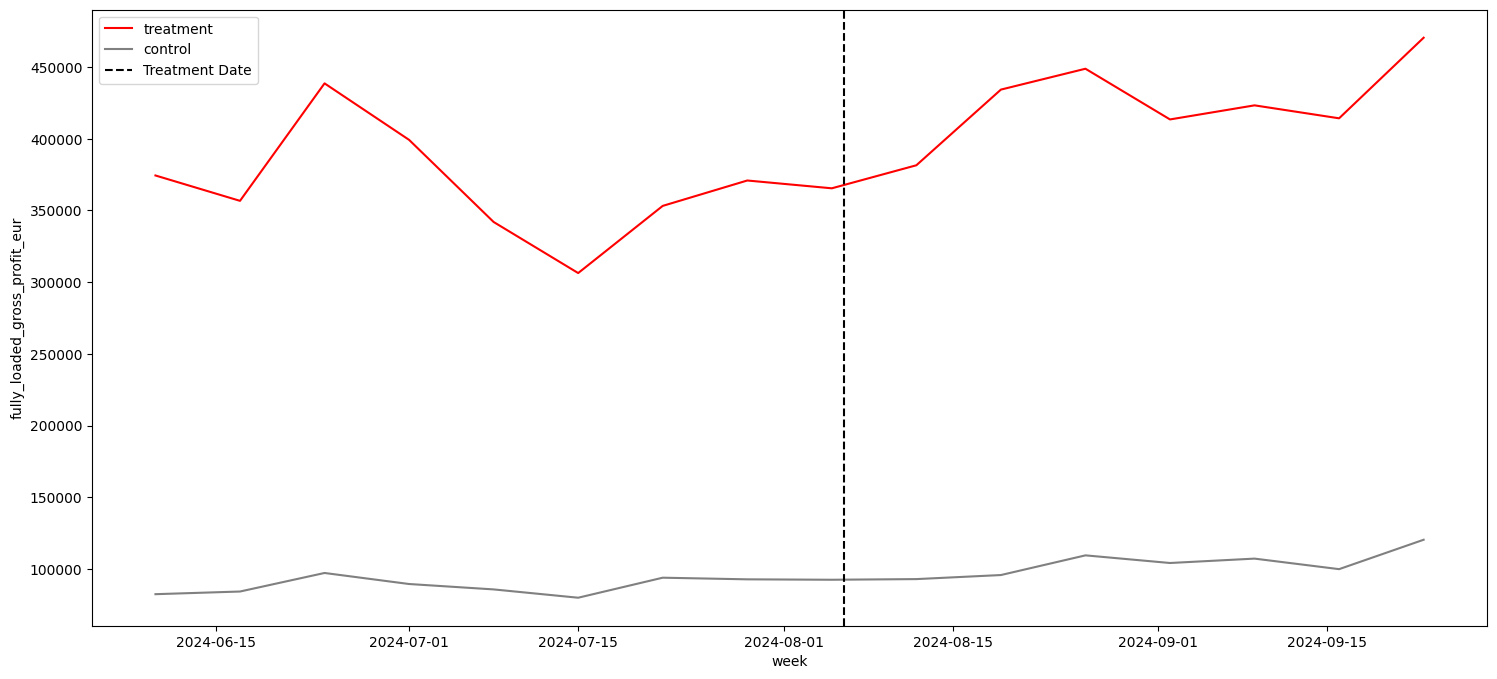

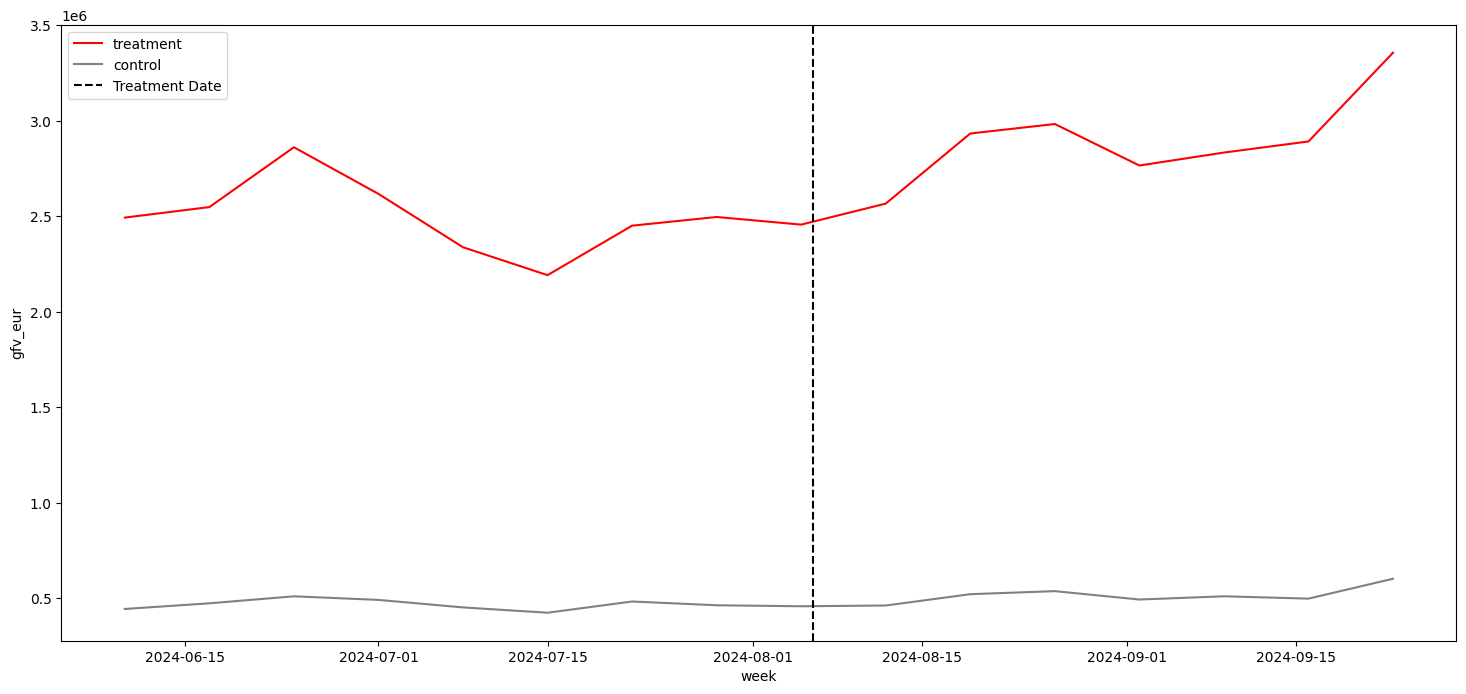

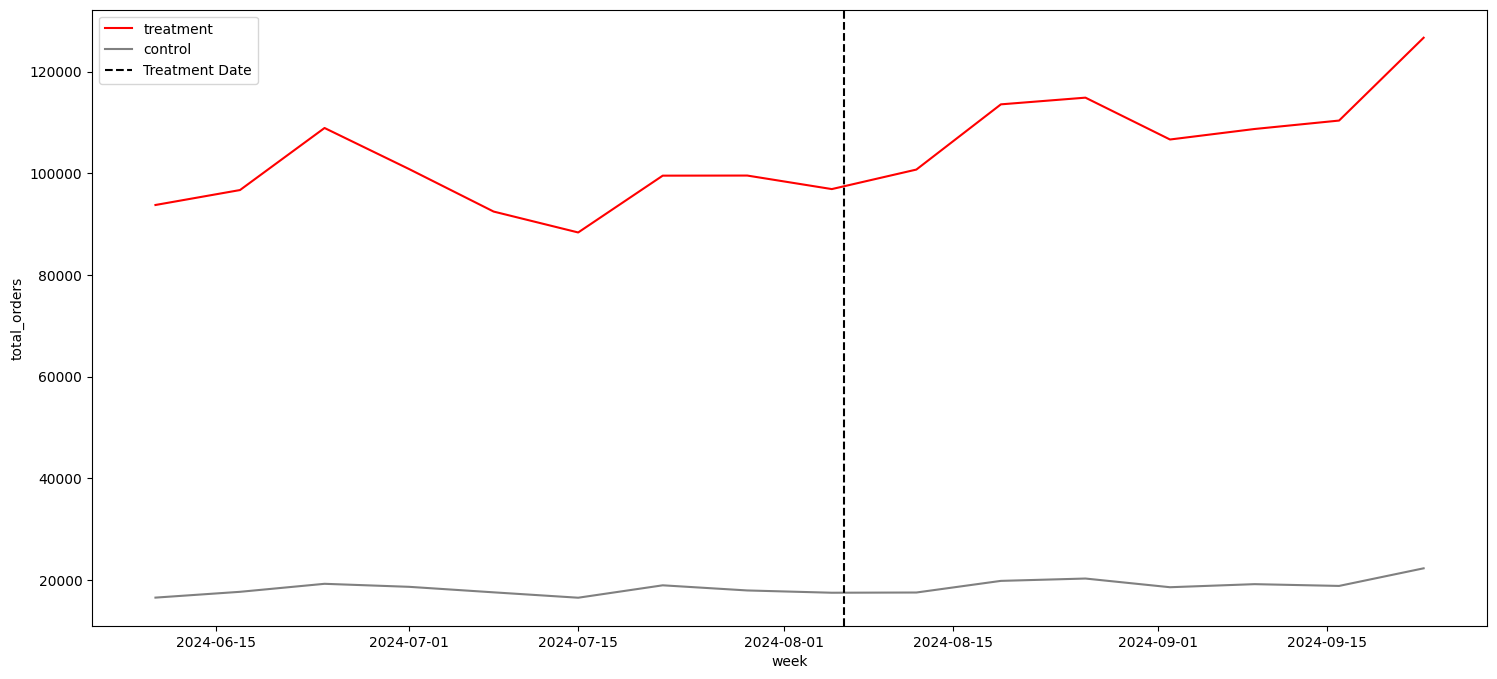

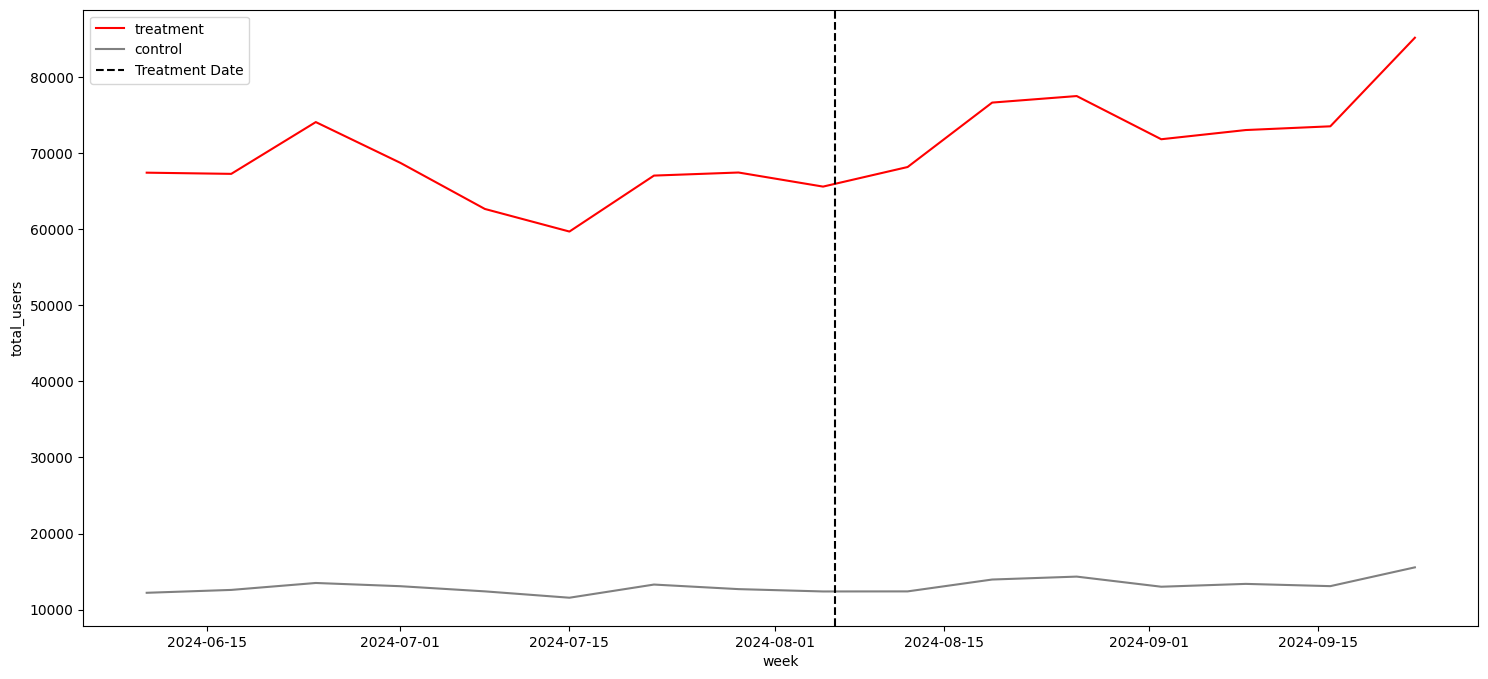

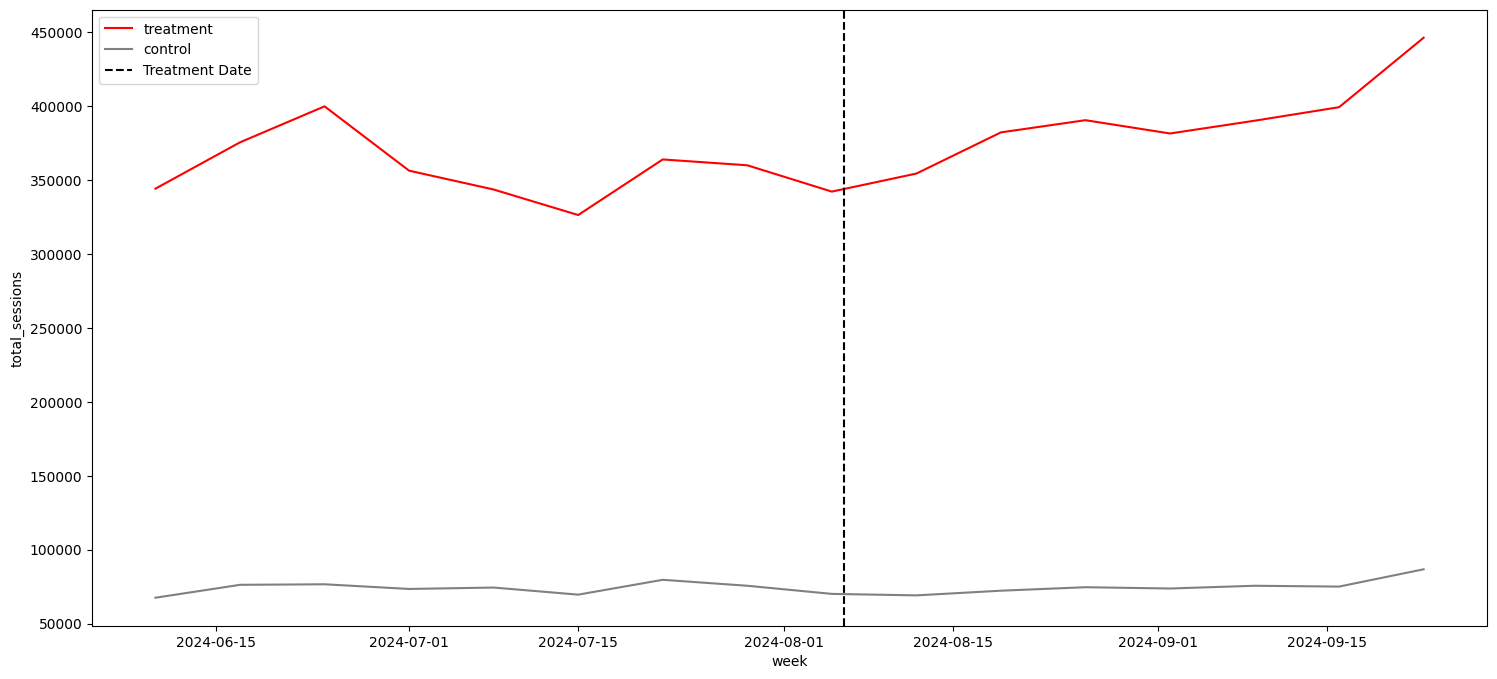

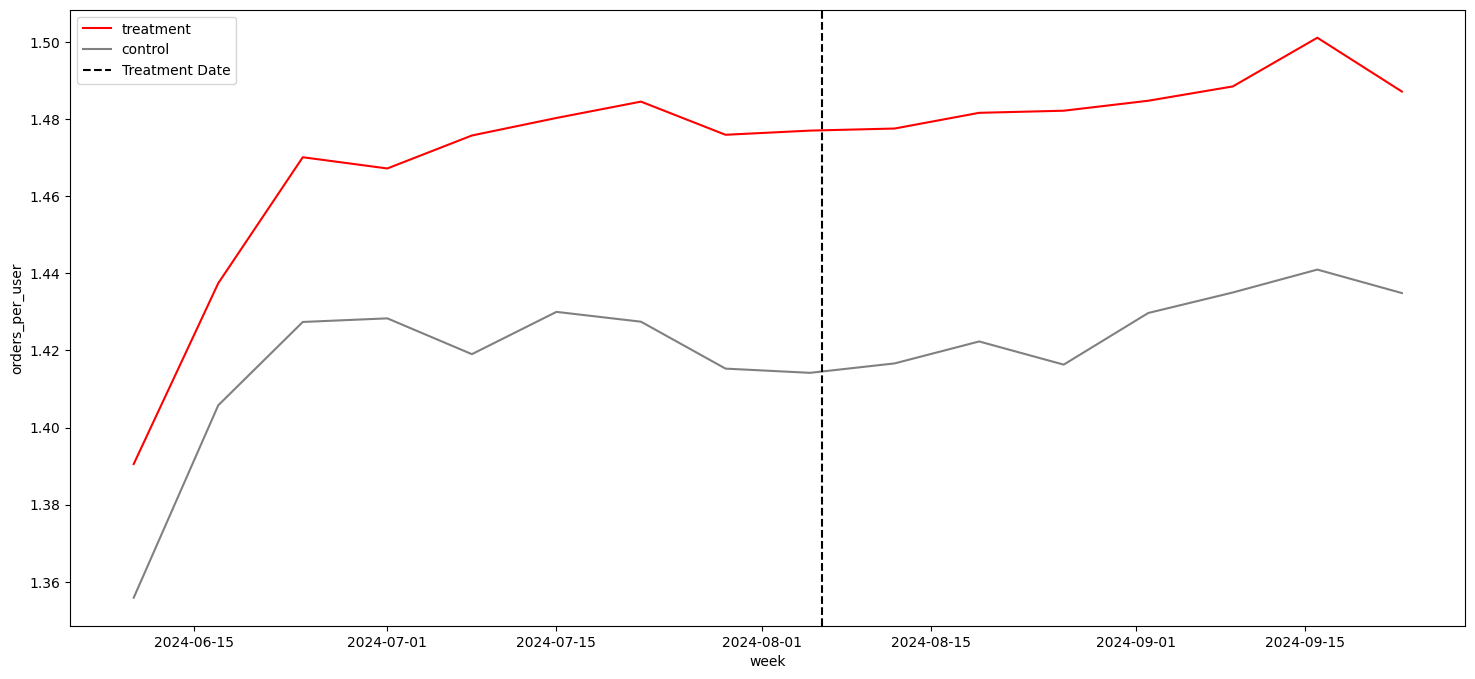

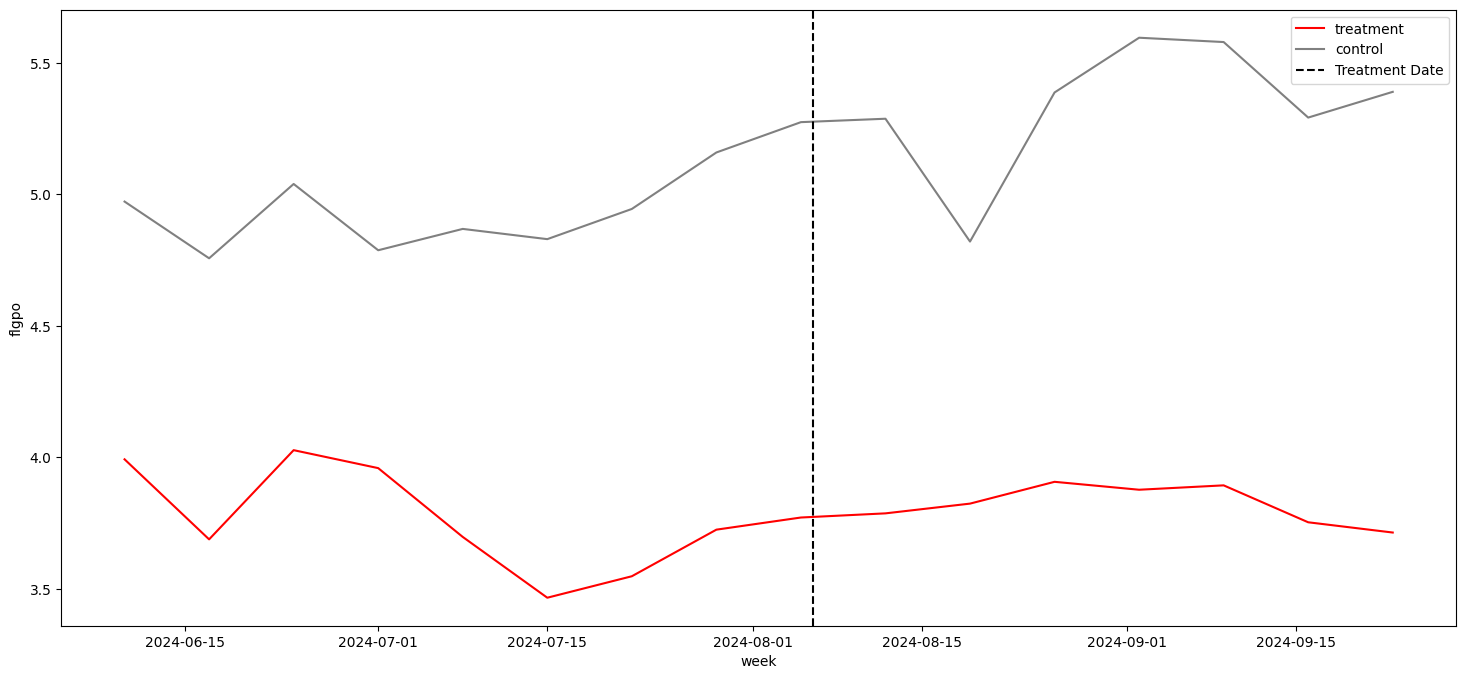

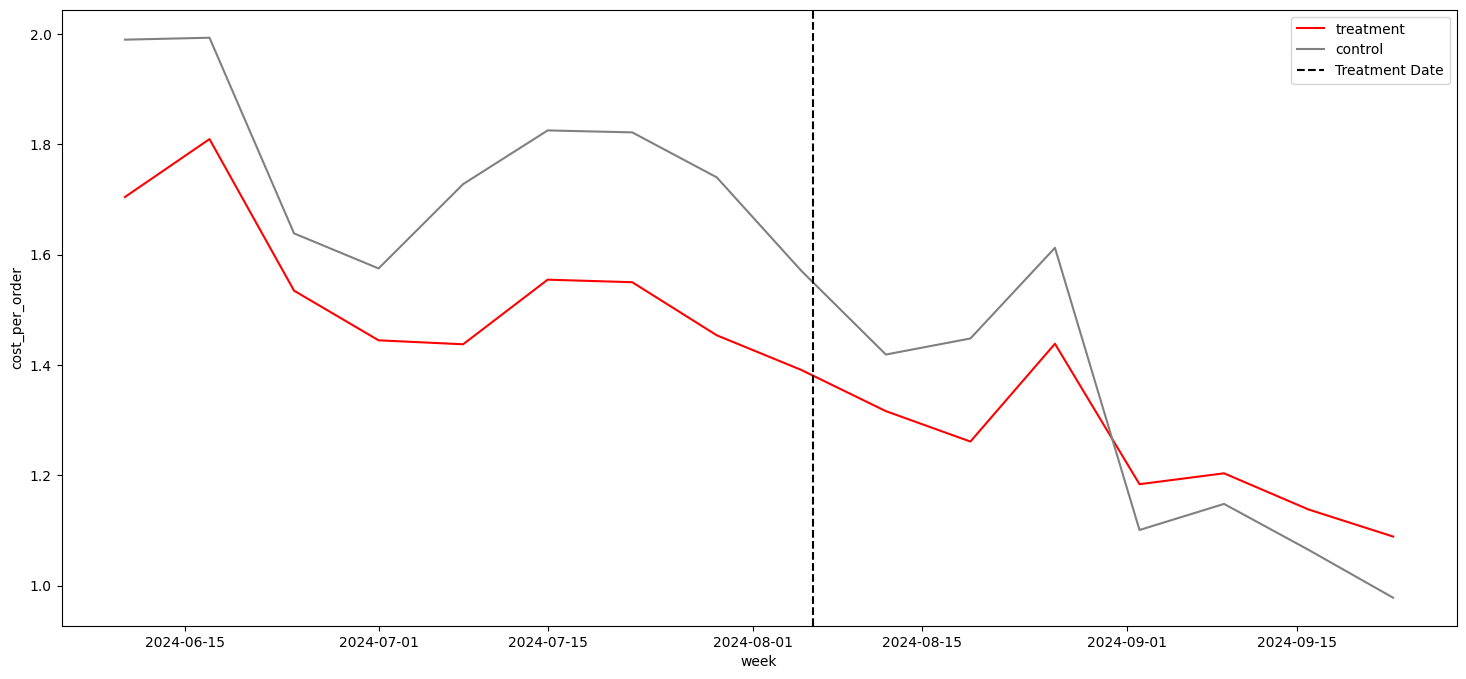

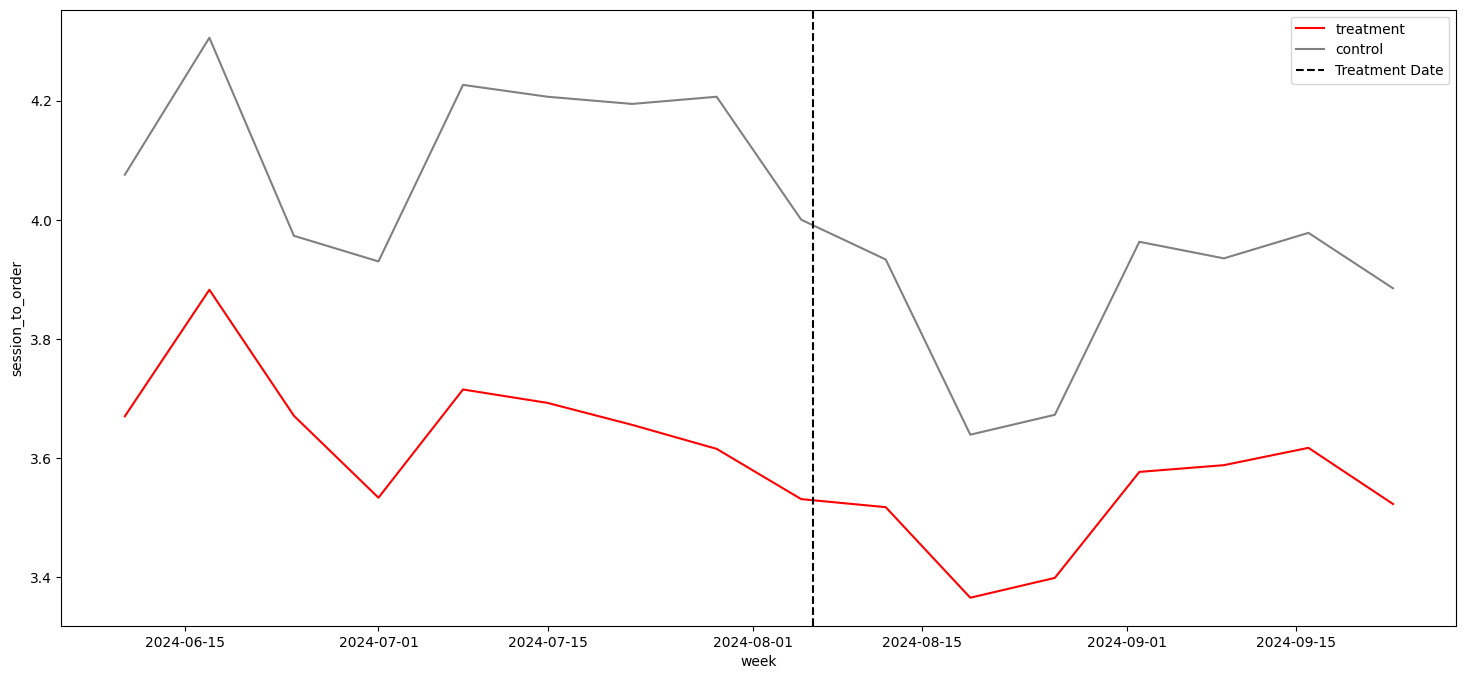

In [500]:
agg_metrics = {'customer_account_id': 'nunique', 
              'platform_order_code': 'nunique',
              'fully_loaded_gross_profit_eur':'sum',
              'gfv_eur':'sum',
              'platform_order_code':'nunique',
              'foregone_delivery_fee':'sum',
              'voucher_amount_eur':'sum',
              'foregone_delivery_fee_final':'sum',
              'voucher_amount_nc_eur':'sum'}

rename_dict = {
    'customer_account_id': 'total_users', 
    'platform_order_code': 'total_orders',
    'fully_loaded_gross_profit_eur': 'fully_loaded_gross_profit_eur',
    'foregone_delivery_fee': 'foregone_delivery_fee',
    'voucher_amount_eur': 'voucher_amount_eur',
    'foregone_delivery_fee_final': 'foregone_delivery_fee_nc',
    'voucher_amount_nc_eur': 'voucher_amount_nc'
}


aggregation_col = 'week'
final_df = create_regression_df(dps_post_treatment, dps_pre_treatment,dps_post_treatment_s, dps_pre_treatment_s, post_control, pre_control,post_control_s,pre_control_s, agg_metrics, aggregation_col)
final_df = final_df.rename(columns=rename_dict)

x_axis = 'week'
y_axis = ['fully_loaded_gross_profit_eur','gfv_eur','total_orders','total_users','total_sessions','orders_per_user','flgpo','cost_per_order','session_to_order']
intervention = '2024-08-06'

for y in y_axis:
    
    plot_metric_trends(final_df, x_axis,y,intervention)


In [501]:
aggregation = 'week'
yvar = ['fully_loaded_gross_profit_eur','total_orders','total_users','total_sessions','gfv_eur']
intervention = '2024-08-06'

for y in yvar:
    plot_did(final_df,intervention, y,aggregation)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/1819534049.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [502]:
# y_variables = ['fully_loaded_gross_profit_eur','total_orders','total_users','total_sessions','flgpo','orders_per_user','session_to_order']  # Add any other dependent variables

# # Example usage with your DataFrame
# results_with_trend_diff = run_panel_ols_with_trend_diff(final_df, 'total_orders', 'week', '2024-08-06')

# # Output the results
# print(results_with_trend_diff)

# # Use the results from PanelOLS or OLS
# stargazer = Stargazer([results_with_trend_diff])
# print(stargazer.render_html())  # Render as HTML

# print(stargazer.render_latex())


In [519]:
# List of y variables to run regression on
y_variables = ['fully_loaded_gross_profit_eur','gfv_eur','total_orders','total_users','total_sessions','flgpo','orders_per_user','session_to_order']

# Placeholder for storing results
results_list = []

# Run regressions for all y variables
for y_var in y_variables:
    results = run_panel_ols_with_trend_diff(final_df, y_var, 'week', '2024-08-06')
    results_list.append(results)

# # Create Stargazer table
# stargazer = Stargazer(results_list)

# # Render LaTeX
# latex_output = stargazer.render_latex()

# print(latex_output)

In [520]:
results_list

[                                PanelOLS Estimation Summary                                
 Dep. Variable:     fully_loaded_gross_profit_eur   R-squared:                        0.4769
 Estimator:                              PanelOLS   R-squared (Between):             -0.0066
 No. Observations:                             32   R-squared (Within):               0.4449
 Date:                           Tue, Oct 15 2024   R-squared (Overall):             -0.0012
 Time:                                   03:18:53   Log-likelihood                   -347.17
 Cov. Estimator:                        Clustered                                           
                                                    F-statistic:                      5.9257
 Entities:                                      2   P-value                           0.0148
 Avg Obs:                                  16.000   Distribution:                    F(2,13)
 Min Obs:                                  16.000                     

In [524]:
import pandas as pd

# Step 1: Organize the results into a DataFrame
data = {
    "y_var": [
        "fully_loaded_gross_profit_eur", "gfv_eur", "total_orders", "total_users", 
        "total_sessions", "flgpo", "orders_per_user", "session_to_order"
    ],
    "coef": [23163.90, 261527.19, 11733.57, 5490.44, 22394.91, -0.62, 0.03, 0.03],
    "ci_low": [-19158.05, 11361.99, 3057.77, 305.95, -10397.13, -0.88, 0.02, -0.07],
    "ci_high": [65485.86, 511692.39, 20409.38, 10674.94, 55186.95, -0.35, 0.03, 0.12],
    "percentage_change": [6.30, 10.48, 12.04, 8.24, 6.28, -16.41, 1.76, 0.70],
    "p_value": [0.2582, 0.0417, 0.0119, 0.0395, 0.1639, 0.0022, 0.0033, 0.0053],  # Example p-values
    "rsquared": [0.4769, 0.5689, 0.5746, 0.5382, 0.4722, 0.3885, 0.4449, 0.5268]  # Example R-squared values
}

# Create the DataFrame
summary_df = pd.DataFrame(data)

# Step 2: Summarize key statistics (mean, standard deviation, etc.)
coef_summary = summary_df['coef'].describe()
ci_low_summary = summary_df['ci_low'].describe()
ci_high_summary = summary_df['ci_high'].describe()
pct_change_summary = summary_df['percentage_change'].describe()

# Print descriptive statistics
print("Coefficient Summary:\n", coef_summary)
print("\nConfidence Interval (Low) Summary:\n", ci_low_summary)
print("\nConfidence Interval (High) Summary:\n", ci_high_summary)
print("\nPercentage Change Summary:\n", pct_change_summary)

# Step 3: Format the output for presentation
# Round values for better readability
summary_df = summary_df.round(2)

# Add a column for formatted confidence intervals
summary_df['conf_interval'] = summary_df.apply(lambda row: f"({row.ci_low}, {row.ci_high})", axis=1)

# Select only the relevant columns for the final summary, including p-values and R-squared
final_summary = summary_df[['y_var', 'coef', 'conf_interval', 'percentage_change', 'p_value', 'rsquared']]

# Transpose the final summary
final_summary_transposed = final_summary.set_index('y_var').T

# Display the transposed final summary
print("\nTransposed Final Summary Table:")
final_summary_transposed

# Optionally, if you want to save the transposed summary to a CSV file
# final_summary_transposed.to_csv('transposed_summary_results.csv')


Coefficient Summary:
 count         8.000000
mean      40538.681250
std       89805.594435
min          -0.620000
25%           0.030000
50%        8612.005000
75%       22587.157500
max      261527.190000
Name: coef, dtype: float64

Confidence Interval (Low) Summary:
 count        8.000000
mean     -1853.800000
std       9150.932637
min     -19158.050000
25%      -2599.942500
50%         -0.025000
75%        993.905000
max      11361.990000
Name: ci_low, dtype: float64

Confidence Interval (High) Summary:
 count         8.000000
mean      82931.165000
std      175121.578749
min          -0.350000
25%           0.097500
50%       15542.160000
75%       57761.677500
max      511692.390000
Name: ci_high, dtype: float64

Percentage Change Summary:
 count     8.000000
mean      3.673750
std       8.997795
min     -16.410000
25%       1.495000
50%       6.290000
75%       8.800000
max      12.040000
Name: percentage_change, dtype: float64

Transposed Final Summary Table:


y_var,fully_loaded_gross_profit_eur,gfv_eur,total_orders,total_users,total_sessions,flgpo,orders_per_user,session_to_order
coef,23163.9,261527.19,11733.57,5490.44,22394.91,-0.62,0.03,0.03
conf_interval,"(-19158.05, 65485.86)","(11361.99, 511692.39)","(3057.77, 20409.38)","(305.95, 10674.94)","(-10397.13, 55186.95)","(-0.88, -0.35)","(0.02, 0.03)","(-0.07, 0.12)"
percentage_change,6.3,10.48,12.04,8.24,6.28,-16.41,1.76,0.7
p_value,0.26,0.04,0.01,0.04,0.16,0.0,0.0,0.01
rsquared,0.48,0.57,0.57,0.54,0.47,0.39,0.44,0.53


In [489]:
y_variables = ['fully_loaded_gross_profit_eur','gfv_eur','total_orders','total_users','total_sessions','flgpo','orders_per_user','session_to_order']  # Add any other dependent variables
results_list = []

for y_var in y_variables:
    result = run_panel_ols_with_trend_diff_plotting(final_df, y_var, 'week', '2024-08-06')
    results_list.append(result)

# Create DataFrame to store all results
df_results = pd.DataFrame(results_list)

df_results = df_results.round(2)

In [490]:
display(df_results)

,y_var,coef,ci_low,ci_high,percentage_change,ci_low_pct,ci_high_pct
0,fully_loaded_gross_profit_eur,23163.90,-19158.05,65485.86,6.30,-5.21,17.82
1,gfv_eur,261527.19,11361.99,511692.39,10.48,0.46,20.51
2,total_orders,11733.57,3057.77,20409.38,12.04,3.14,20.95
3,total_users,5490.44,305.95,10674.94,8.24,0.46,16.01
4,total_sessions,22394.91,-10397.13,55186.95,6.28,-2.91,15.47
5,flgpo,-0.62,-0.88,-0.35,-16.41,-23.45,-9.37
6,orders_per_user,0.03,0.02,0.03,1.76,1.30,2.22
7,session_to_order,0.03,-0.07,0.12,0.70,-1.97,3.37


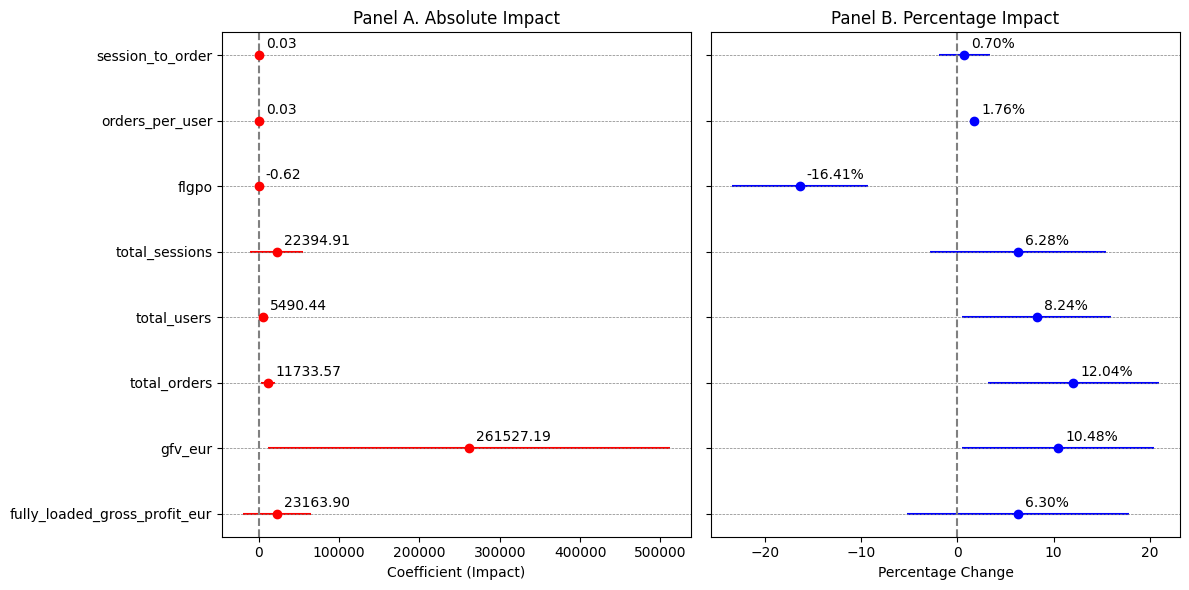

In [491]:
# Creating the chart
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Panel A: Absolute change
axes[0].errorbar(df_results['coef'], df_results['y_var'], 
                 xerr=[df_results['coef'] - df_results['ci_low'], df_results['ci_high'] - df_results['coef']], 
                 fmt='o', color='red', label='Impact on Number')
axes[0].axvline(x=0, color='grey', linestyle='--')
axes[0].set_title('Panel A. Absolute Impact')
axes[0].set_xlabel('Coefficient (Impact)')

# Add horizontal dashed lines for each y axis value
for i, y_var in enumerate(df_results['y_var']):
    axes[0].axhline(y=i, color='grey', linestyle='--', linewidth=0.5)

# Panel B: Percentage change
axes[1].errorbar(df_results['percentage_change'], df_results['y_var'], 
                 xerr=[df_results['percentage_change'] - df_results['ci_low_pct'], 
                       df_results['ci_high_pct'] - df_results['percentage_change']], 
                 fmt='o', color='blue', label='Impact on Percentage')
axes[1].axvline(x=0, color='grey', linestyle='--')
axes[1].set_title('Panel B. Percentage Impact')
axes[1].set_xlabel('Percentage Change')

# Add horizontal dashed lines for each y axis value
for i, y_var in enumerate(df_results['y_var']):
    axes[1].axhline(y=i, color='grey', linestyle='--', linewidth=0.5)

# Adding annotations for coefficients
for i, (coef, y_var) in enumerate(zip(df_results['coef'], df_results['y_var'])):
    axes[0].annotate(f'{coef:.2f}', xy=(coef, i), xytext=(5, 5), textcoords='offset points', color='black')

# Adding annotations for percentage changes
for i, (pct_change, y_var) in enumerate(zip(df_results['percentage_change'], df_results['y_var'])):
    axes[1].annotate(f'{pct_change:.2f}%', xy=(pct_change, i), xytext=(5, 5), textcoords='offset points', color='black')

# Final touches
plt.tight_layout()
plt.show()

In [533]:
entity_id = 'PO_FI'

## Treatment Cities ##
city_treatment = ('Helsinki','Oulu')
city_str_treatment = ",".join([f"'{c}'" for c in city_treatment])

## Control Cities  ##
city_control = ('Tampere','Turku')
city_str_control = ",".join([f"'{c}'" for c in city_control])

### post time period ###
start_date_post = '2024-08-19'
end_date_post = '2024-09-29'

print(f'start date of post treatment: {start_date_post}')
print(f'end date of post treatment: {end_date_post}')


### pre time period ###

## start date pre control calcualtion ##

#convert string date to date format#
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

#calculate the difference in days between start and end date#
days_difference = (end_date - start_date).days
days_difference

print(f'Difference in days between start and end date of post treatment: {days_difference}')

# Subtract the number of days from start date to get start date of pre treatment period#
new_start_datetime = start_date - timedelta(days=days_difference)
new_start_date = new_start_datetime.date()
new_start_date = new_start_date.strftime("%Y-%m-%d")
start_date_pre = new_start_date

## end date pre treatment calcualtion ##

tmp_datetime = datetime.strptime(start_date_post, '%Y-%m-%d')
new_end_datetime = tmp_datetime - timedelta(days=1)
new_end_date = new_end_datetime.strftime('%Y-%m-%d')
end_date_pre = new_end_date

print(f'start date of pre treatment: {start_date_pre}')
print(f'end date of pre treatment: {end_date_pre}')


### Treatment analysis ### 
### post dataframe ###
dps_post_treatment = client.query(dps_all_f(city_str_treatment, entity_id, start_date_post, end_date_post)).to_dataframe()
dps_post_treatment = add_foregone_delivery_fee(dps_post_treatment)
dps_post_treatment_s = client.query(sessions(entity_id, city_str_treatment, start_date_post, end_date_post)).to_dataframe()

### pre dataframe ###
dps_pre_treatment = client.query(dps_all_f(city_str_treatment, entity_id, start_date_pre, end_date_pre)).to_dataframe()
dps_pre_treatment = add_foregone_delivery_fee(dps_pre_treatment)
dps_pre_treatment_s = client.query(sessions(entity_id, city_str_treatment, start_date_pre, end_date_pre)).to_dataframe()


# summary treatment #
print(f'Post treatment summary')
display(cities_summary(dps_pre_treatment, dps_pre_treatment_s, dps_post_treatment, dps_post_treatment_s))

### Control analysis ###
### post dataframe ###
post_control = client.query(dps_all_f(city_str_control, entity_id, start_date_post, end_date_post)).to_dataframe()
post_control = add_foregone_delivery_fee(post_control)
post_control_s = client.query(sessions(entity_id, city_str_control, start_date_post, end_date_post)).to_dataframe()

### pre dataframe ###
pre_control = client.query(dps_all_f(city_str_control, entity_id, start_date_pre, end_date_pre)).to_dataframe()
pre_control = add_foregone_delivery_fee(pre_control)
pre_control_s = client.query(sessions(entity_id, city_str_control, start_date_pre, end_date_pre)).to_dataframe()

# summary control #
print(f'Pre treatment summary')
display(cities_summary(pre_control, pre_control_s, post_control, post_control_s))

start date of post treatment: 2024-08-19
end date of post treatment: 2024-09-29
Difference in days between start and end date of post treatment: 41
start date of pre treatment: 2024-07-09
end date of pre treatment: 2024-08-18
Post treatment summary


entity_id_period,PO_FI_pre,PO_FI_post,percentage_change
Acquistions,74675,73638,-1.388684
FDNC_cost_eur,73742,184163,149.739633
FLGP_eur,77592,-33391,-143.034076
Orders,175761,177756,1.135064
Stacked_orders,5515,21951,298.023572
Voucher_cost_eur,216975,331836,52.937435
gfv_eur,4549446,4398203,-3.324427
total_acquistion_cost,290717,515999,77.491856
total_sessions,799309,851515,6.531391


Pre treatment summary


entity_id_period,PO_FI_pre,PO_FI_post,percentage_change
Acquistions,36555,38978,6.628368
FDNC_cost_eur,49133,92352,87.963283
FLGP_eur,120898,38401,-68.236861
Orders,89049,96260,8.097789
Stacked_orders,2441,9467,287.832855
Voucher_cost_eur,101547,161641,59.178508
gfv_eur,2173291,2298728,5.771754
total_acquistion_cost,150680,253993,68.564508
total_sessions,377263,413496,9.604175


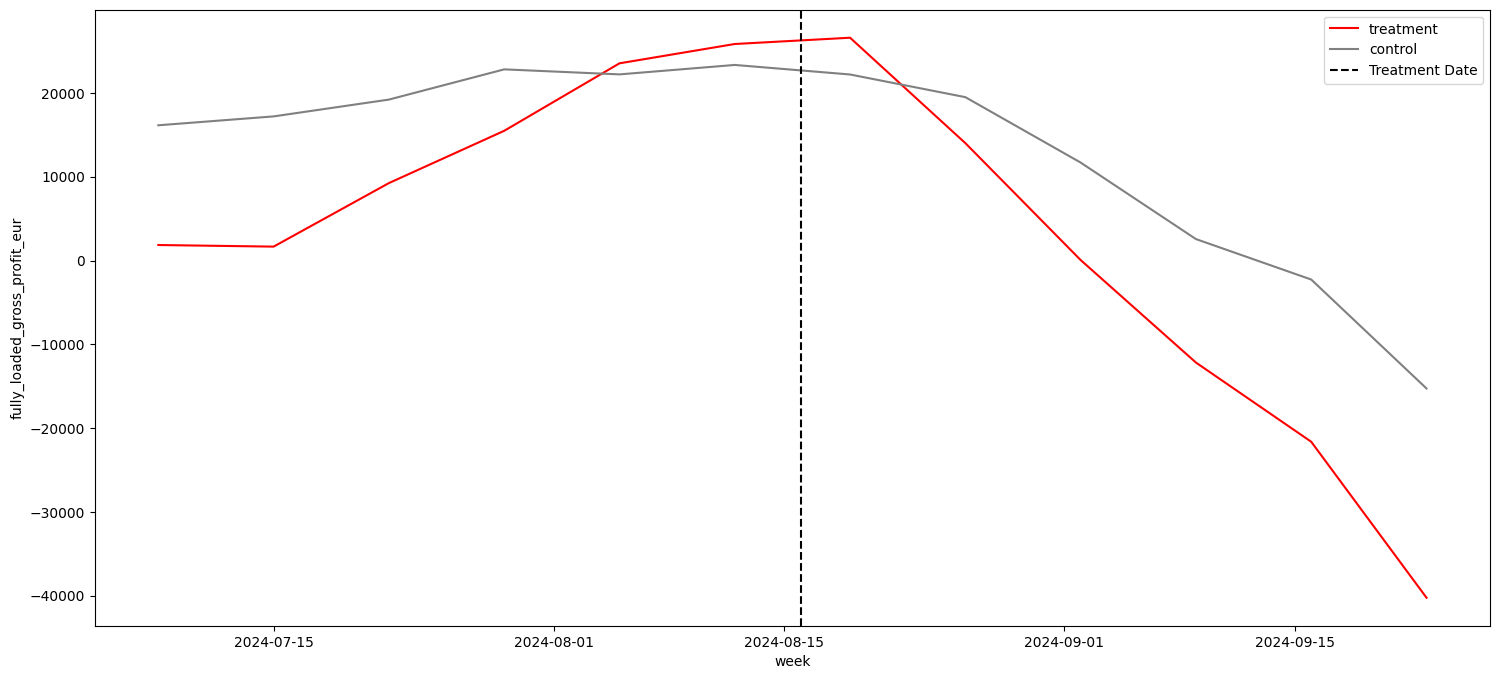

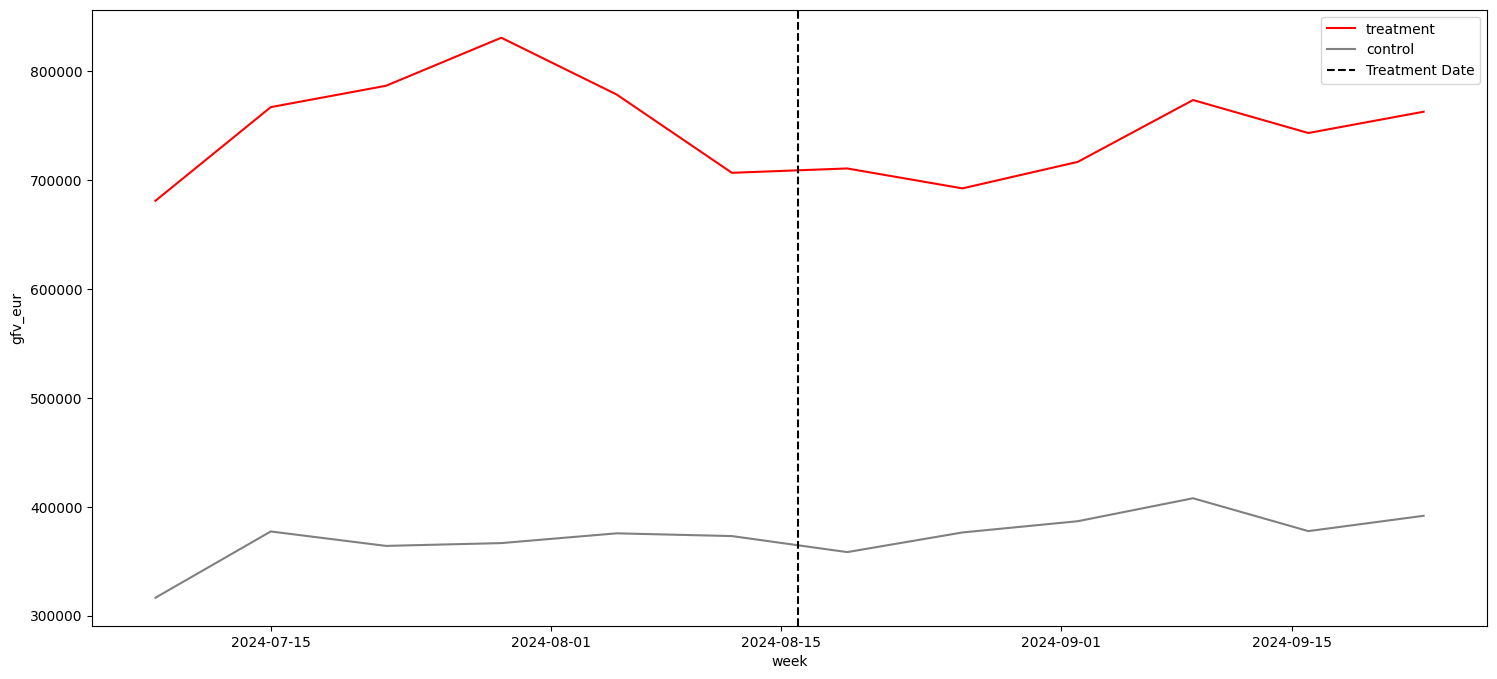

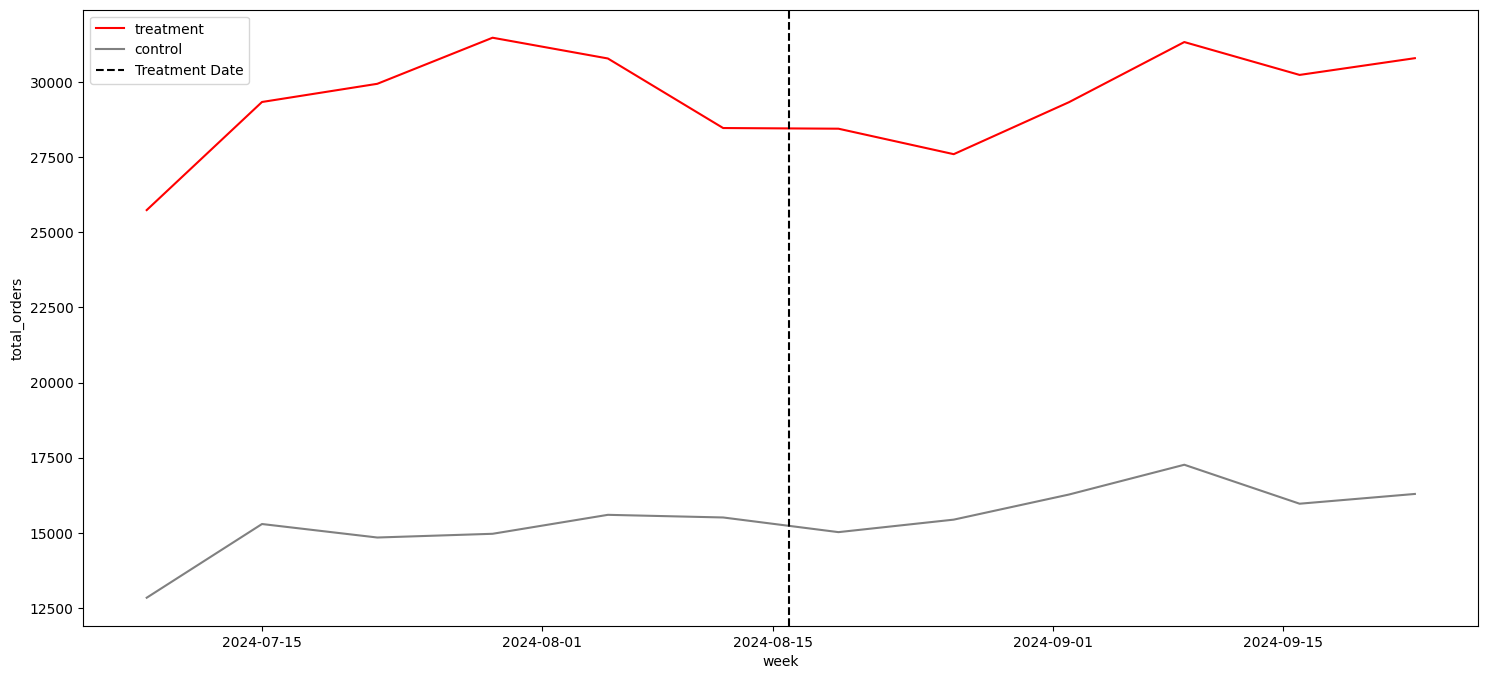

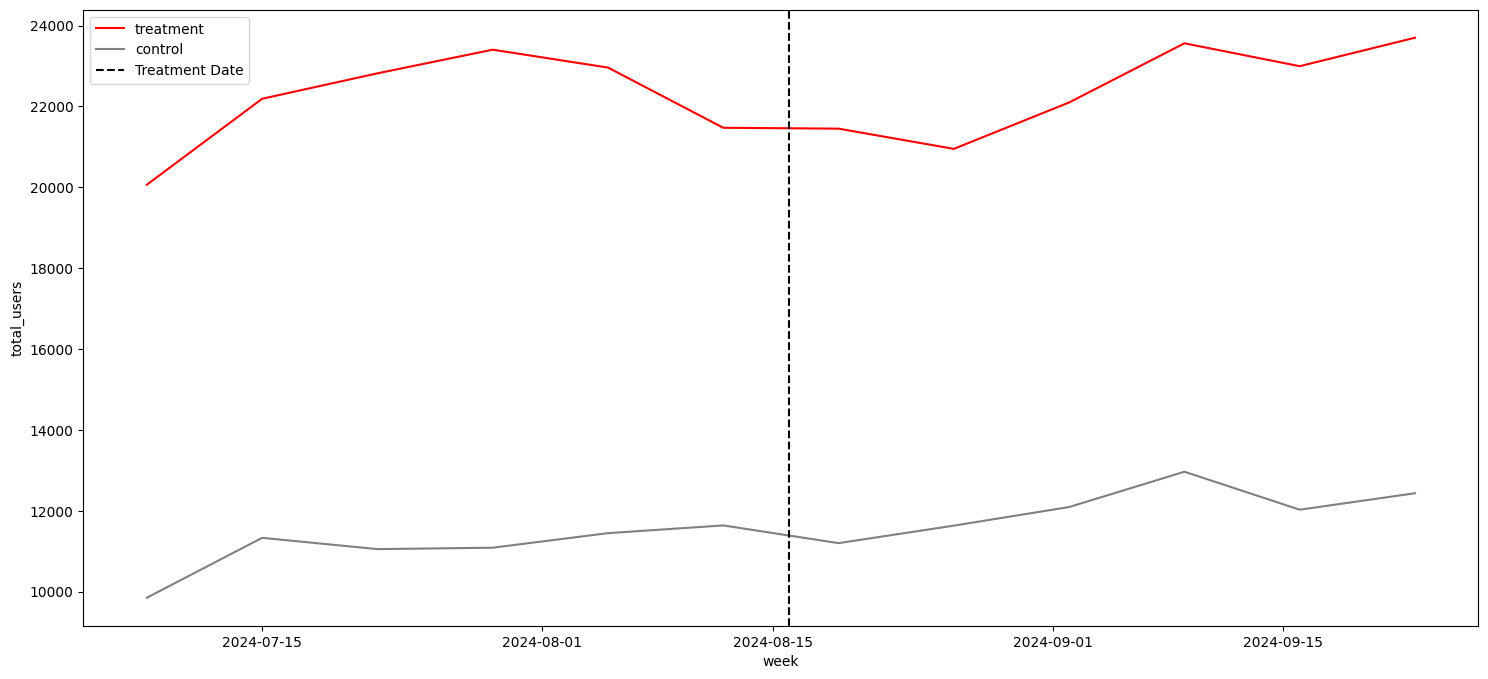

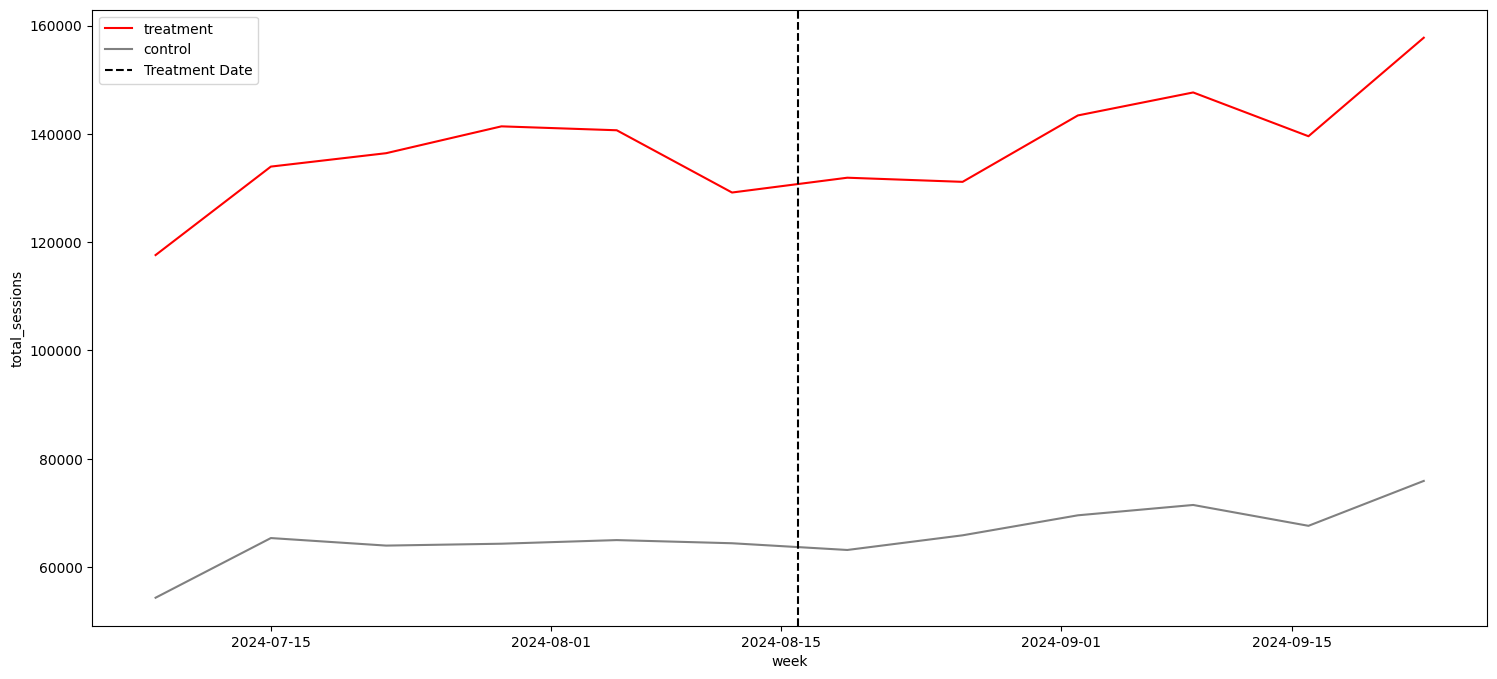

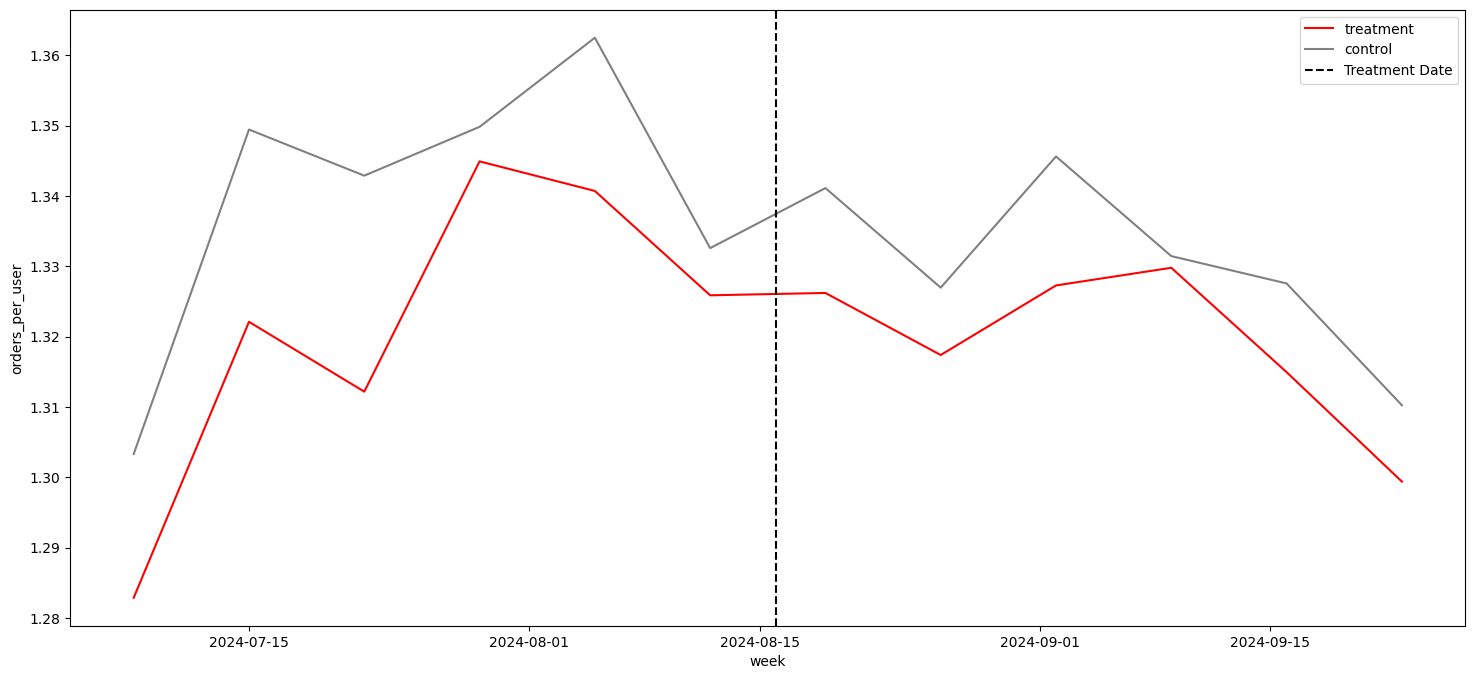

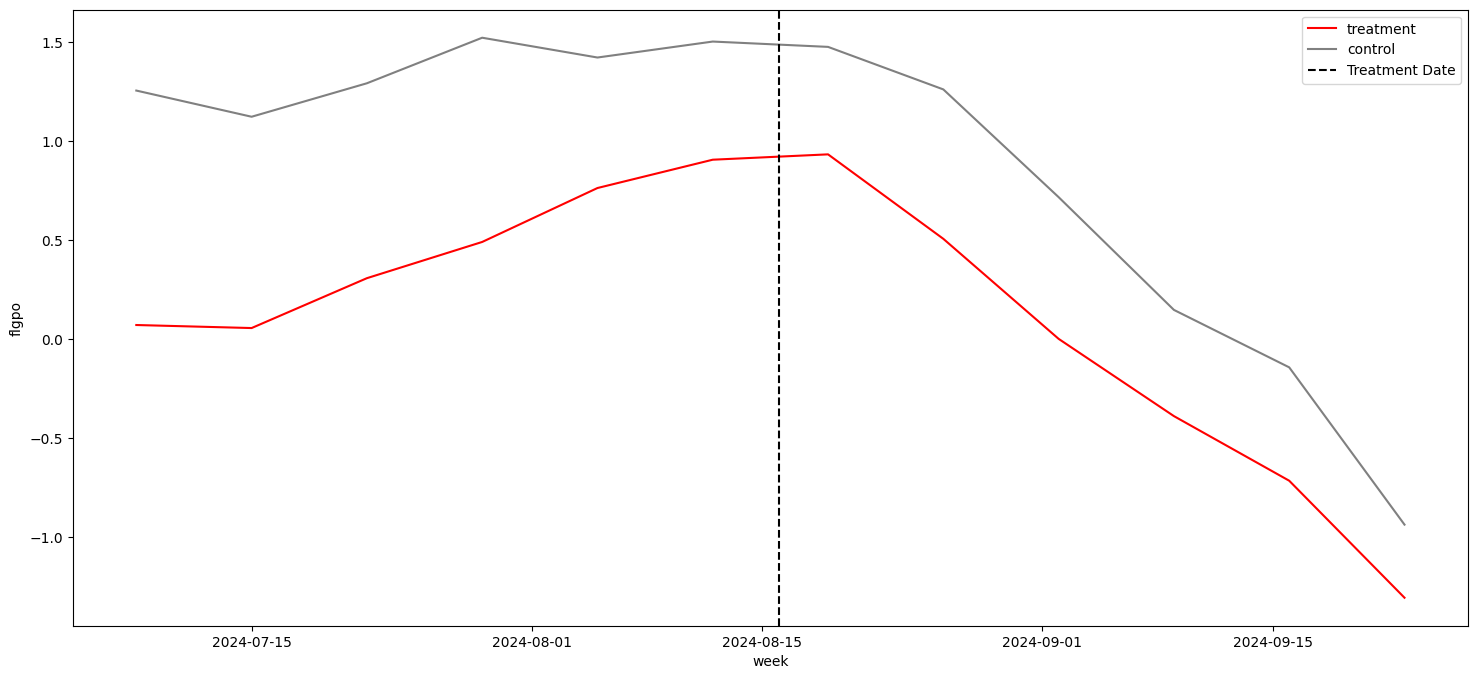

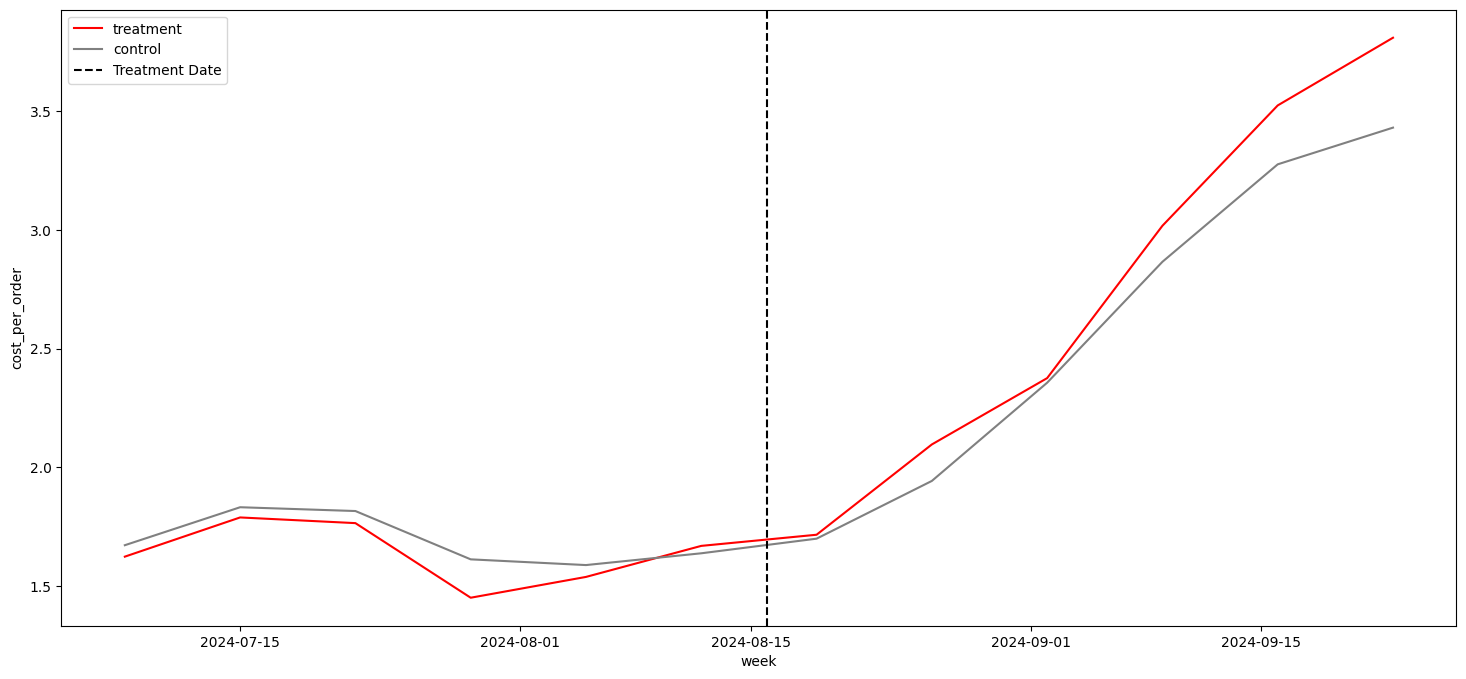

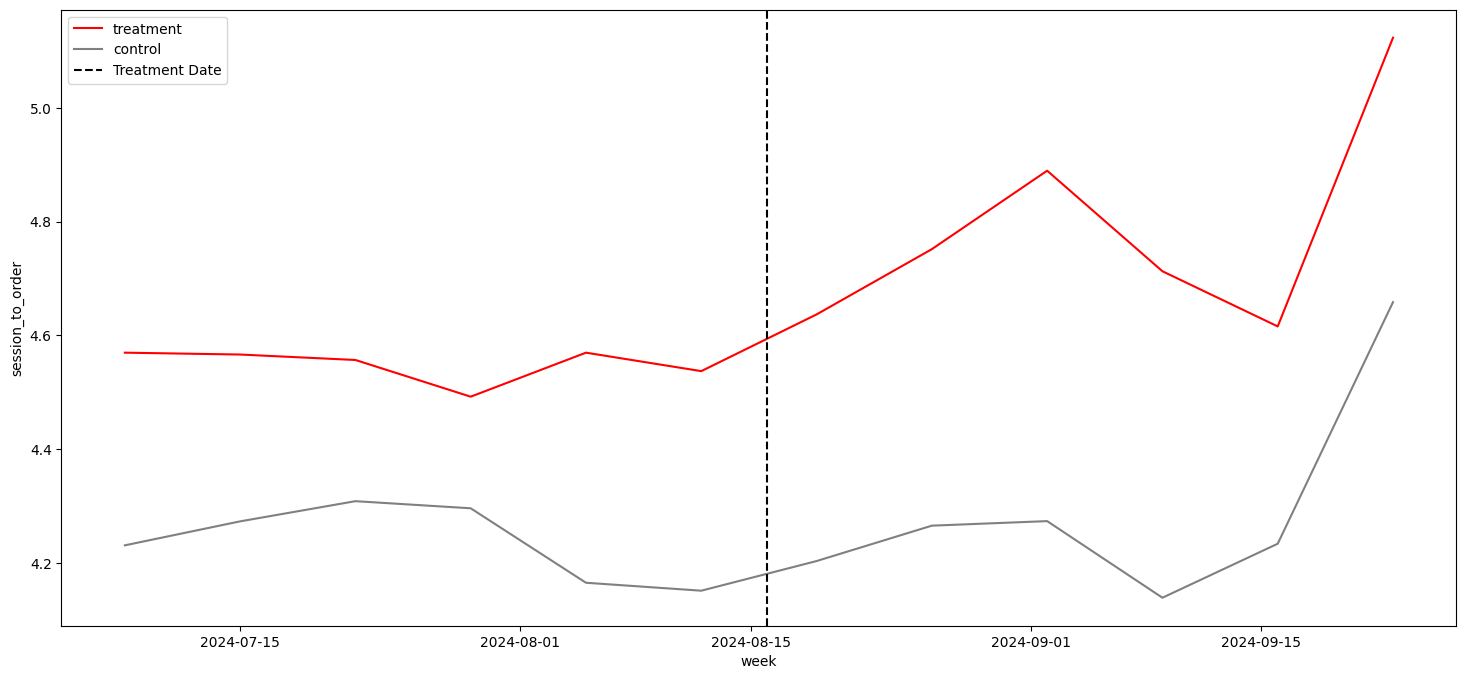

In [534]:
agg_metrics = {'customer_account_id': 'nunique', 
              'platform_order_code': 'nunique',
              'fully_loaded_gross_profit_eur':'sum',
              'gfv_eur':'sum',
              'platform_order_code':'nunique',
              'foregone_delivery_fee':'sum',
              'voucher_amount_eur':'sum',
              'foregone_delivery_fee_final':'sum',
              'voucher_amount_nc_eur':'sum'}

rename_dict = {
    'customer_account_id': 'total_users', 
    'platform_order_code': 'total_orders',
    'fully_loaded_gross_profit_eur': 'fully_loaded_gross_profit_eur',
    'foregone_delivery_fee': 'foregone_delivery_fee',
    'voucher_amount_eur': 'voucher_amount_eur',
    'foregone_delivery_fee_final': 'foregone_delivery_fee_nc',
    'voucher_amount_nc_eur': 'voucher_amount_nc'
}


aggregation_col = 'week'
final_df = create_regression_df(dps_post_treatment, dps_pre_treatment,dps_post_treatment_s, dps_pre_treatment_s, post_control, pre_control,post_control_s,pre_control_s, agg_metrics, aggregation_col)
final_df = final_df.rename(columns=rename_dict)

x_axis = 'week'
y_axis = ['fully_loaded_gross_profit_eur','gfv_eur','total_orders','total_users','total_sessions','orders_per_user','flgpo','cost_per_order','session_to_order']
intervention = '2024-08-16'

for y in y_axis:
    
    plot_metric_trends(final_df, x_axis,y,intervention)


In [535]:
aggregation = 'week'
yvar = ['fully_loaded_gross_profit_eur','total_orders','total_users','total_sessions','gfv_eur']
intervention = '2024-08-16'

for y in yvar:
    plot_did(final_df,intervention, y,aggregation)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:324: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:325: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_29872/2410984556.py:334: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [536]:
# List of y variables to run regression on
y_variables = ['fully_loaded_gross_profit_eur','gfv_eur','total_orders','total_users','total_sessions','flgpo','orders_per_user','session_to_order']

# Placeholder for storing results
results_list = []

# Run regressions for all y variables
for y_var in y_variables:
    results = run_panel_ols_with_trend_diff(final_df, y_var, 'week', '2024-08-06')
    results_list.append(results)

# # Create Stargazer table
# stargazer = Stargazer(results_list)

# # Render LaTeX
# latex_output = stargazer.render_latex()

# print(latex_output)

In [537]:
results_list

[                                PanelOLS Estimation Summary                                
 Dep. Variable:     fully_loaded_gross_profit_eur   R-squared:                        0.1739
 Estimator:                              PanelOLS   R-squared (Between):             -0.0034
 No. Observations:                             24   R-squared (Within):               0.0558
 Date:                           Tue, Oct 15 2024   R-squared (Overall):              0.0398
 Time:                                   12:08:49   Log-likelihood                   -232.76
 Cov. Estimator:                        Clustered                                           
                                                    F-statistic:                      0.9475
 Entities:                                      2   P-value                           0.4232
 Avg Obs:                                  12.000   Distribution:                     F(2,9)
 Min Obs:                                  12.000                     

In [540]:
import pandas as pd

# Step 1: Organize the regression results into a DataFrame
data = {
    "y_var": [
        "fully_loaded_gross_profit_eur", "gfv_eur", "total_orders", "total_users", 
        "total_sessions", "flgpo", "orders_per_user", "session_to_order"
    ],
    "coef": [7146.7, -30730.0, 151.60, -202.26, 7041.1, 0.6189, 0.0143, 0.1882],
    "ci_low": [-4143.4, -66530.0, -1010.8, -1085.2, 795.84, 0.4835, 0.0030, 0.0612],
    "ci_high": [18440.0, 5071.2, 1314.0, 680.69, 13290.0, 0.7544, 0.0256, 0.3152],
    "p_value": [0.1860, 0.0841, 0.7747, 0.6168, 0.0312, 0.0000, 0.0186, 0.0085],
    "rsquared": [0.1739, 0.6851, 0.5924, 0.5533, 0.3164, 0.8146, 0.3977, 0.5651],
}

# Create the DataFrame
summary_df = pd.DataFrame(data)

# Step 2: Summarize key statistics (mean, standard deviation, etc.)
coef_summary = summary_df['coef'].describe()
ci_low_summary = summary_df['ci_low'].describe()
ci_high_summary = summary_df['ci_high'].describe()
pct_change_summary = summary_df['p_value'].describe()

# Print descriptive statistics
print("Coefficient Summary:\n", coef_summary)
print("\nConfidence Interval (Low) Summary:\n", ci_low_summary)
print("\nConfidence Interval (High) Summary:\n", ci_high_summary)
print("\nP-value Summary:\n", pct_change_summary)

# Step 3: Format the output for presentation
# Round values for better readability
summary_df = summary_df.round(4)

# Add a column for formatted confidence intervals
summary_df['conf_interval'] = summary_df.apply(lambda row: f"({row.ci_low}, {row.ci_high})", axis=1)

# Select only the relevant columns for the final summary, including p-values and R-squared
final_summary = summary_df[['y_var', 'coef', 'conf_interval', 'p_value', 'rsquared']]

# Transpose the final summary
final_summary_transposed = final_summary.set_index('y_var').T

# Display the transposed final summary
print("\nTransposed Final Summary Table:")
final_summary_transposed

# Optionally, if you want to save the transposed summary to a CSV file
# final_summary_transposed.to_csv('transposed_summary_results.csv')


Coefficient Summary:
 count        8.000000
mean     -2074.004825
std      12015.687568
min     -30730.000000
25%        -50.554275
50%          0.403550
75%       1873.975000
max       7146.700000
Name: coef, dtype: float64

Confidence Interval (Low) Summary:
 count        8.000000
mean     -8996.626537
std      23295.392213
min     -66530.000000
25%      -1849.750000
50%       -505.398500
75%          0.166775
max        795.840000
Name: ci_low, dtype: float64

Confidence Interval (High) Summary:
 count        8.000000
mean      4849.623150
std       7135.564323
min          0.025600
25%          0.644600
50%        997.345000
75%       7125.900000
max      18440.000000
Name: ci_high, dtype: float64

P-value Summary:
 count    8.000000
mean     0.214988
std      0.305639
min      0.000000
25%      0.016075
50%      0.057650
75%      0.293700
max      0.774700
Name: p_value, dtype: float64

Transposed Final Summary Table:


y_var,fully_loaded_gross_profit_eur,gfv_eur,total_orders,total_users,total_sessions,flgpo,orders_per_user,session_to_order
coef,7146.7,-30730.0,151.6,-202.26,7041.1,0.6189,0.0143,0.1882
conf_interval,"(-4143.4, 18440.0)","(-66530.0, 5071.2)","(-1010.8, 1314.0)","(-1085.2, 680.69)","(795.84, 13290.0)","(0.4835, 0.7544)","(0.003, 0.0256)","(0.0612, 0.3152)"
p_value,0.186,0.0841,0.7747,0.6168,0.0312,0.0,0.0186,0.0085
rsquared,0.1739,0.6851,0.5924,0.5533,0.3164,0.8146,0.3977,0.5651


In [541]:
y_variables = ['fully_loaded_gross_profit_eur','gfv_eur','total_orders','total_users','total_sessions','flgpo','orders_per_user','session_to_order']  # Add any other dependent variables
results_list = []

for y_var in y_variables:
    result = run_panel_ols_with_trend_diff_plotting(final_df, y_var, 'week', '2024-08-06')
    results_list.append(result)

# Create DataFrame to store all results
df_results = pd.DataFrame(results_list)

df_results = df_results.round(2)



In [543]:
df_results

,y_var,coef,ci_low,ci_high,percentage_change,ci_low_pct,ci_high_pct
0,fully_loaded_gross_profit_eur,7146.72,-4143.45,18436.89,69.04,-40.03,178.12
1,gfv_eur,-30731.56,-66534.33,5071.21,-4.00,-8.66,0.66
2,total_orders,151.60,-1010.79,1313.99,0.51,-3.43,4.46
3,total_users,-202.26,-1085.20,680.69,-0.91,-4.87,3.05
4,total_sessions,7041.11,795.84,13286.39,5.25,0.59,9.91
5,flgpo,0.62,0.48,0.75,182.81,142.79,222.82
6,orders_per_user,0.01,0.00,0.03,1.08,0.23,1.94
7,session_to_order,0.19,0.06,0.32,4.14,1.34,6.93


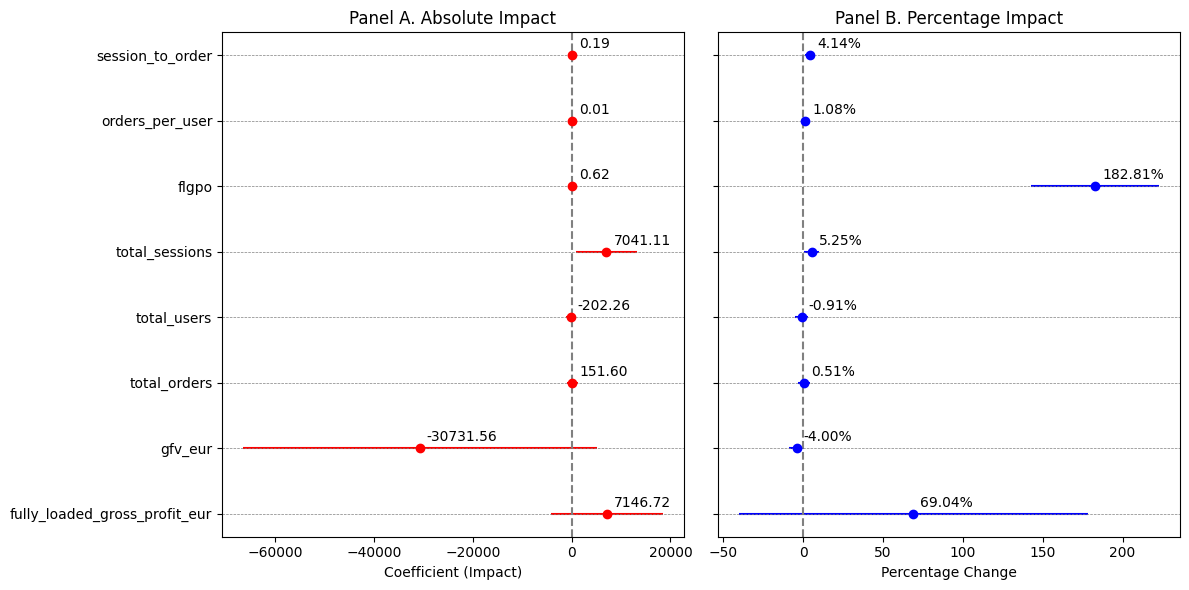

In [542]:
# Creating the chart
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Panel A: Absolute change
axes[0].errorbar(df_results['coef'], df_results['y_var'], 
                 xerr=[df_results['coef'] - df_results['ci_low'], df_results['ci_high'] - df_results['coef']], 
                 fmt='o', color='red', label='Impact on Number')
axes[0].axvline(x=0, color='grey', linestyle='--')
axes[0].set_title('Panel A. Absolute Impact')
axes[0].set_xlabel('Coefficient (Impact)')

# Add horizontal dashed lines for each y axis value
for i, y_var in enumerate(df_results['y_var']):
    axes[0].axhline(y=i, color='grey', linestyle='--', linewidth=0.5)

# Panel B: Percentage change
axes[1].errorbar(df_results['percentage_change'], df_results['y_var'], 
                 xerr=[df_results['percentage_change'] - df_results['ci_low_pct'], 
                       df_results['ci_high_pct'] - df_results['percentage_change']], 
                 fmt='o', color='blue', label='Impact on Percentage')
axes[1].axvline(x=0, color='grey', linestyle='--')
axes[1].set_title('Panel B. Percentage Impact')
axes[1].set_xlabel('Percentage Change')

# Add horizontal dashed lines for each y axis value
for i, y_var in enumerate(df_results['y_var']):
    axes[1].axhline(y=i, color='grey', linestyle='--', linewidth=0.5)

# Adding annotations for coefficients
for i, (coef, y_var) in enumerate(zip(df_results['coef'], df_results['y_var'])):
    axes[0].annotate(f'{coef:.2f}', xy=(coef, i), xytext=(5, 5), textcoords='offset points', color='black')

# Adding annotations for percentage changes
for i, (pct_change, y_var) in enumerate(zip(df_results['percentage_change'], df_results['y_var'])):
    axes[1].annotate(f'{pct_change:.2f}%', xy=(pct_change, i), xytext=(5, 5), textcoords='offset points', color='black')

# Final touches
plt.tight_layout()
plt.show()

In [507]:

# def run_panel_ols_with_trend_diff(df, y_var, agg_col, intervention_date_str):
#     # Convert intervention_date to datetime
#     intervention_date = pd.to_datetime(intervention_date_str, format='%Y-%m-%d')

#     # Convert week column to datetime
#     df[agg_col] = pd.to_datetime(df[agg_col], errors='coerce')

#     # Creating flags for treatment and post-intervention period
#     df['variant_cities'] = df['group'] == 'treatment'
#     df['after'] = df[agg_col] >= intervention_date
#     df['treated'] = 1 * (df['variant_cities'] & df['after'])

#     # Create a numeric version of the week column for trend estimation
#     df['week_numeric'] = (df[agg_col] - df[agg_col].min()).dt.days / 7

#     # Create a flag for the pre-intervention period to specifically capture differences in trends before the intervention
#     df['pre_intervention'] = df[agg_col] < intervention_date

#     # Interaction term between pre-intervention time trend and treatment group
#     df['pre_trend_diff'] = df['variant_cities'] * df['week_numeric'] * df['pre_intervention']

#     # Set 'group' and 'week' as a multi-level index for PanelOLS
#     df = df.set_index(['group', agg_col])

#     # Define and fit the PanelOLS model, adding the pre-intervention trend interaction
#     formula = f'{y_var} ~ treated + pre_trend_diff + EntityEffects + TimeEffects'
#     model = PanelOLS.from_formula(formula, data=df)

#     # Fitting the model
#     results = model.fit(cov_type='clustered', cluster_entity=False)

#     # Extracting coefficient, confidence intervals
#     coef = results.params['treated']
#     ci_low, ci_high = results.conf_int().loc['treated']

#     # Calculating baseline mean in the treatment group before the intervention
#     baseline_mean = df.loc[
#         (df['variant_cities'] == True) & (df['after'] == False), y_var
#     ].mean()

#     # Calculating percentage change
#     percentage_change = (coef / baseline_mean) * 100
#     ci_low_pct = (ci_low / baseline_mean) * 100
#     ci_high_pct = (ci_high / baseline_mean) * 100

#     return {
#         'y_var': y_var,
#         'coef': coef,
#         'ci_low': ci_low,
#         'ci_high': ci_high,
#         'percentage_change': percentage_change,
#         'ci_low_pct': ci_low_pct,
#         'ci_high_pct': ci_high_pct
#     }

In [420]:
# def create_regression_df(post_treatment, pre_treatment, post_s_treatment, pre_s_treatment, post_control, pre_control, post_s_control, pre_s_control, agg_metrics, aggregation):
    
#     # Aggregate post-treatment data
#     a = post_treatment.groupby([aggregation]).agg(agg_metrics).reset_index()
#     a_s = post_s_treatment.groupby([aggregation]).agg({'total_sessions': 'sum'}).reset_index()
#     a = a.merge(a_s, on=aggregation, how='left')
#     a[a.select_dtypes(include=['number']).columns] = a.select_dtypes(include=['number']).fillna(0)
    
#     # Aggregate pre-treatment data
#     b = pre_treatment.groupby([aggregation]).agg(agg_metrics).reset_index()
#     b_s = pre_s_treatment.groupby([aggregation]).agg({'total_sessions': 'sum'}).reset_index()
#     b = b.merge(b_s, on=aggregation, how='left')
#     b[b.select_dtypes(include=['number']).columns] = b.select_dtypes(include=['number']).fillna(0)

#     # Aggregate post-control data
#     c = post_control.groupby([aggregation]).agg(agg_metrics).reset_index()
#     c_s = post_s_control.groupby([aggregation]).agg({'total_sessions': 'sum'}).reset_index()
#     c = c.merge(c_s, on=aggregation, how='left')
#     c[c.select_dtypes(include=['number']).columns] = c.select_dtypes(include=['number']).fillna(0)

#     # Aggregate pre-control data
#     d = pre_control.groupby([aggregation]).agg(agg_metrics).reset_index()
#     d_s = pre_s_control.groupby([aggregation]).agg({'total_sessions': 'sum'}).reset_index()
#     d = d.merge(d_s, on=aggregation, how='left')
#     d[d.select_dtypes(include=['number']).columns] = d.select_dtypes(include=['number']).fillna(0)

#     # Combine treatment data
#     combined_treatment = pd.concat([a, b])
#     combined_treatment['group'] = 'treatment'

#     # Combine control data
#     combined_control = pd.concat([c, d])
#     combined_control['group'] = 'control'

#     # Combine treatment and control data
#     final_df = pd.concat([combined_treatment, combined_control])
    
#     # Convert 'foregone_delivery_fee_final' and 'voucher_amount_nc_eur' to float before summing
#     final_df['foregone_delivery_fee_final'] = final_df['foregone_delivery_fee_final'].astype(float)
#     final_df['voucher_amount_nc_eur'] = final_df['voucher_amount_nc_eur'].astype(float)

#     # Calculate total cost
#     final_df['total_cost'] = final_df['foregone_delivery_fee_final'] + final_df['voucher_amount_nc_eur']

#     # Calculate average metrics per order
#     final_df['orders_per_user'] = final_df['platform_order_code'] / final_df['customer_account_id']
#     final_df['flgpo'] = final_df['fully_loaded_gross_profit_eur'] / final_df['platform_order_code']
#     final_df['cost_per_order'] = final_df['total_cost'] / final_df['platform_order_code']
#     final_df['session_to_order'] = final_df['total_sessions'] / final_df['platform_order_code']

#     return final_df


In [421]:
# import pandas as pd
# import plotly.express as px
# from sklearn.linear_model import LinearRegression

# def plot_did(df, intervention_date, metric, aggregation):
#     # Ensure the week column is in datetime format
#     df[aggregation] = pd.to_datetime(df[aggregation], errors='coerce')

#     # Ensure metric column is numeric
#     df[metric] = pd.to_numeric(df[metric], errors='coerce')

#     # Drop rows with missing values in either column
#     df_clean = df.dropna(subset=[aggregation, metric])

#     # Convert metric column to numeric types
#     df_clean[metric] = df_clean[metric].astype(float)

#     # Separate control and treatment groups
#     control_group = df_clean[df_clean['group'] == 'control'].copy()
#     treatment_group = df_clean[df_clean['group'] == 'treatment'].copy()

#     # Split control and treatment groups into pre- and post-intervention
#     control_pre = control_group[control_group[aggregation] < intervention_date]
#     control_post = control_group[control_group[aggregation] >= intervention_date]
#     treatment_pre = treatment_group[treatment_group[aggregation] < intervention_date]
#     treatment_post = treatment_group[treatment_group[aggregation] >= intervention_date]

#     # Convert datetime to numeric (days from minimum date) for regression purposes
#     treatment_pre['date_numeric'] = (treatment_pre[aggregation] - treatment_pre[aggregation].min()).dt.days
#     treatment_post['date_numeric'] = (treatment_post[aggregation] - treatment_pre[aggregation].min()).dt.days

#     # Linear regression model for pre-intervention data
#     model_pre = LinearRegression()
#     X_pre = treatment_pre[['date_numeric']]
#     y_pre = treatment_pre[metric]
#     model_pre.fit(X_pre, y_pre)

#     # Predict values for the pre-intervention period to plot the line
#     treatment_pre['predicted_pre'] = model_pre.predict(treatment_pre[['date_numeric']])

#     # Predict values for the post-intervention period using the pre-intervention model to ensure continuity
#     treatment_post['predicted_pre'] = model_pre.predict(treatment_post[['date_numeric']])

#     # Linear regression model for post-intervention data (separate model)
#     model_post = LinearRegression()
#     X_post = treatment_post[['date_numeric']]
#     y_post = treatment_post[metric]
#     model_post.fit(X_post, y_post)

#     # Predict values for the post-intervention period using the post-intervention model
#     treatment_post['predicted_post'] = model_post.predict(treatment_post[['date_numeric']])

#     # Combine pre- and post-intervention predictions for the green line
#     treatment_combined = pd.concat([treatment_pre[[aggregation, 'predicted_pre']],
#                                     treatment_post[[aggregation, 'predicted_pre']]])

#     # Scatter plot for the control group pre-intervention with regression line (extended for post-intervention)
#     fig = px.scatter(
#         control_group,
#         x=aggregation,
#         y=metric,
#         trendline='ols',  # Regression line for entire control group
#         trendline_scope='overall',  # Apply regression to the entire control group
#         color_discrete_sequence=['blue'],  # Control group in blue
#     )

#     # Plot scatter for post-intervention control data only
#     fig.add_trace(
#         px.scatter(
#             control_post,
#             x=aggregation,
#             y=metric,
#             color_discrete_sequence=['blue'],  # Post-intervention control in light blue
#         ).data[0]  # Add only the scatter trace (no regression line for post)
#     )

#     # Scatter plot for the treatment group pre-intervention
#     fig.add_trace(
#         px.scatter(
#             treatment_pre,
#             x=aggregation,
#             y=metric,
#             color_discrete_sequence=['green'],  # Pre-intervention treatment in green
#         ).data[0]  # Add scatter trace for pre-intervention
#     )

#     # Add continuous pre-intervention regression line (green) spanning both periods
#     fig.add_trace(
#         px.line(
#             treatment_combined,
#             x=aggregation,
#             y='predicted_pre',
#             color_discrete_sequence=['green'],  # Pre-intervention and post-intervention line in green
#         ).data[0]  # Add continuous line trace for pre- and post-intervention predicted values
#     )

#     # Scatter plot for post-intervention treatment data
#     fig.add_trace(
#         px.scatter(
#             treatment_post,
#             x=aggregation,
#             y=metric,
#             color_discrete_sequence=['red'],  # Post-intervention treatment in red
#         ).data[0]  # Add scatter trace for post-intervention
#     )

#     # Add post-intervention regression line (red)
#     fig.add_trace(
#         px.line(
#             treatment_post,
#             x=aggregation,
#             y='predicted_post',
#             color_discrete_sequence=['red'],  # Post-intervention line in red
#         ).data[0]  # Add line trace for post-intervention regression
#     )

#     # Update layout for better visualization
#     fig.update_layout(
#         xaxis_title='Created Date',
#         yaxis_title=metric,
#         yaxis_range=[0, None],  # Start y-axis at 0
#         legend_title='Group',
#         height=400,  # Height of the plot
#         width=800,  # Width of the plot
#         showlegend=False  # Hide duplicate legends from added traces
#     )

#     # Add a vertical dotted line at the intervention date
#     fig.add_shape(
#         type="line",
#         x0=intervention_date,
#         y0=0,
#         x1=intervention_date,
#         y1=df[metric].max(),  # Set the y1 to the max value of metric
#         line=dict(
#             color="Black",
#             width=2,
#             dash="dot",  # Dotted line
#         ),
#     )

#     # Add annotation to label the intervention date
#     fig.add_annotation(
#         x=intervention_date,
#         y=df[metric].max(),
#         text="Intervention Date",
#         showarrow=False,
#         yshift=10,
#     )

#     # Adding annotations for the green, red, and blue lines
#     # Green line annotation
#     fig.add_annotation(
#         x=treatment_pre[aggregation].min(),  # Start of the green line
#         y=treatment_pre['predicted_pre'].max(),
#         text="Treatment Pre-Intervention",
#         showarrow=True,
#         arrowhead=2,
#         ax=0,
#         ay=-40,
#         font=dict(color="green")
#     )

#     # Red line annotation
#     fig.add_annotation(
#         x=treatment_post[aggregation].max(),  # End of the red line
#         y=treatment_post['predicted_post'].max(),
#         text="Treatment Post-Intervention",
#         showarrow=True,
#         arrowhead=2,
#         ax=0,
#         ay=-40,
#         font=dict(color="red")
#     )

#     # Blue line annotation (Control group regression line)
#     fig.add_annotation(
#         x=control_group[aggregation].min(),  # Start of the control line
#         y=control_group[metric].mean(),  # Roughly place it near the mean
#         text="Control Group",
#         showarrow=True,
#         arrowhead=2,
#         ax=0,
#         ay=-40,
#         font=dict(color="blue")
#     )

#     # Show the plot with the vertical line
#     fig.show()

# # Example of how to call this function
# # plot_did(final_df, '2024-08-06', 'metric_column_name', 'week_column_name')


In [305]:
# import pandas as pd
# import plotly.express as px


# # Example intervention date (replace this with your actual intervention date)
# intervention_date = '2024-08-05'

# # Ensure created_date_local is in datetime format
# final_df['week'] = pd.to_datetime(final_df['week'], errors='coerce')

# # Ensure platform_order_code is numeric
# final_df['customer_account_id'] = pd.to_numeric(final_df['total_orders'], errors='coerce')
# #final_df['log_customer_account_id'] = np.log(final_df_clean['customer_account_id'] + 1)  # Adding 1 to avoid log(0) errors


# # Drop rows with missing values in either column
# final_df_clean = final_df.dropna(subset=['week', 'customer_account_id'])

# # Separate control and treatment groups
# control_group = final_df_clean[final_df_clean['group'] == 'control']
# treatment_group = final_df_clean[final_df_clean['group'] == 'treatment']

# # Split control group into pre- and post-intervention
# control_pre = control_group[control_group['week'] < intervention_date]
# control_post = control_group[control_group['week'] >= intervention_date]

# # Split treatment group into pre- and post-intervention
# treatment_pre = treatment_group[treatment_group['week'] < intervention_date]
# treatment_post = treatment_group[treatment_group['week'] >= intervention_date]

# # Scatter plot for the control group (pre-intervention) with regression line and confidence intervals
# fig = px.scatter(
#     control_pre,
#     x='week',
#     y='customer_account_id',
#     color_discrete_sequence=['blue'],  # Pre-intervention control in blue
#     trendline='ols',  # Regression line for pre-intervention control
#     trendline_scope='trace',  # Ensures confidence intervals are plotted
#     trendline_color_override='blue'
# )

# # Add confidence intervals for the pre-intervention control group
# fig.add_trace(
#     px.scatter(
#         control_pre,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['blue'],
#         trendline='ols',  # Regression line for pre-intervention control
#         trendline_scope='trace',  # Ensures confidence intervals are plotted
#         trendline_color_override='blue'
#     ).data[1]  # Selecting only the trendline trace
# )

# # Scatter plot for the control group (post-intervention) with regression line and confidence intervals
# fig.add_trace(
#     px.scatter(
#         control_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['lightblue'],  # Post-intervention control in light blue
#         trendline='ols',  # Regression line for post-intervention control
#         trendline_scope='trace',  # Ensures confidence intervals are plotted
#         trendline_color_override='lightblue'
#     ).data[0]  # Selecting only the scatter trace
# )

# fig.add_trace(
#     px.scatter(
#         control_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['lightblue'],
#         trendline='ols',  # Regression line for post-intervention control
#         trendline_scope='trace',  # Ensures confidence intervals are plotted
#         trendline_color_override='lightblue'
#     ).data[1]  # Selecting only the trendline trace
# )

# # Scatter plot for the treatment group (pre-intervention) with regression line and confidence intervals
# fig.add_trace(
#     px.scatter(
#         treatment_pre,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['green'],  # Pre-intervention treatment in green
#         trendline='ols',  # Regression line for pre-intervention treatment
#         trendline_scope='trace',  # Ensures confidence intervals are plotted
#         trendline_color_override='green'
#     ).data[0]  # Selecting only the scatter trace
# )

# fig.add_trace(
#     px.scatter(
#         treatment_pre,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['green'],
#         trendline='ols',  # Regression line for pre-intervention treatment
#         trendline_scope='trace',  # Ensures confidence intervals are plotted
#         trendline_color_override='green'
#     ).data[1]  # Selecting only the trendline trace
# )

# # Scatter plot for the treatment group (post-intervention) with regression line and confidence intervals
# fig.add_trace(
#     px.scatter(
#         treatment_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['red'],  # Post-intervention treatment in red
#         trendline='ols',  # Regression line for post-intervention treatment
#         trendline_scope='trace',  # Ensures confidence intervals are plotted
#         trendline_color_override='red'
#     ).data[0]  # Selecting only the scatter trace
# )

# fig.add_trace(
#     px.scatter(
#         treatment_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['red'],
#         trendline='ols',  # Regression line for post-intervention treatment
#         trendline_scope='trace',  # Ensures confidence intervals are plotted
#         trendline_color_override='red'
#     ).data[1]  # Selecting only the trendline trace
# )

# # Update layout for better visualization
# fig.update_layout(
#     xaxis_title='week',
#     yaxis_title='Log Customer Account ID',
#     yaxis_range=[0, None],  # Start y-axis at 0
#     legend_title='Group',
#     height=600,  # Height of the plot
#     width=1200,  # Width of the plot
#     showlegend=False  # Hide duplicate legends from added traces
# )

# # Show the plot
# fig.show()

In [306]:
# import pandas as pd
# import plotly.express as px

# # Example intervention date (replace this with your actual intervention date)
# intervention_date = '2024-08-05'

# # Ensure created_date_local is in datetime format
# final_df['week'] = pd.to_datetime(final_df['week'], errors='coerce')

# # Ensure platform_order_code is numeric
# final_df['customer_account_id'] = pd.to_numeric(final_df['customer_account_id'], errors='coerce')

# # Drop rows with missing values in either column
# final_df_clean = final_df.dropna(subset=['week', 'customer_account_id'])

# # Separate control and treatment groups
# control_group = final_df_clean[final_df_clean['group'] == 'control']
# treatment_group = final_df_clean[final_df_clean['group'] == 'treatment']

# # Split control group into pre- and post-intervention
# control_pre = control_group[control_group['week'] < intervention_date]
# control_post = control_group[control_group['week'] >= intervention_date]

# # Split treatment group into pre- and post-intervention
# treatment_pre = treatment_group[treatment_group['week'] < intervention_date]
# treatment_post = treatment_group[treatment_group['week'] >= intervention_date]

# # Plot for control group pre-intervention with regression line extended into post-intervention
# fig = px.scatter(
#     control_group,
#     x='week',
#     y='customer_account_id',
#     trendline='ols',  # Regression line for entire control group
#     trendline_scope='overall',  # Apply regression to the entire control group
#     color_discrete_sequence=['blue'],  # Control group in blue
# )

# # Plot scatter for post-intervention control data only
# fig.add_trace(
#     px.scatter(
#         control_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['lightblue'],  # Post-intervention control in light blue
#     ).data[0]  # Add only the scatter trace (no regression line for post)
# )

# # Scatter plot and regression line for the treatment group pre-intervention
# fig.add_trace(
#     px.scatter(
#         treatment_pre,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['green'],  # Pre-intervention treatment in green
#         trendline='ols',  # Regression line for pre-intervention treatment
#         trendline_scope='trace',  # Separate trendline for treatment pre
#     ).data[0]  # Adding scatter trace
# )

# # Add treatment pre-intervention regression line
# fig.add_trace(
#     px.scatter(
#         treatment_pre,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['green'], 
#         trendline='ols',
#         trendline_scope='trace',
#     ).data[1]  # Adding trendline trace
# )

# # Scatter plot for the treatment group post-intervention
# fig.add_trace(
#     px.scatter(
#         treatment_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['red'],  # Post-intervention treatment in red
#     ).data[0]  # Add only the scatter trace
# )

# # Add treatment post-intervention regression line
# fig.add_trace(
#     px.scatter(
#         treatment_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['red'],
#         trendline='ols',
#         trendline_scope='trace',
#     ).data[1]  # Add trendline trace
# )

# # Update layout for better visualization
# fig.update_layout(
#     xaxis_title='Created Date',
#     yaxis_title='Customer Account ID',
#     yaxis_range=[0, None],  # Start y-axis at 0
#     legend_title='Group',
#     height=600,  # Height of the plot
#     width=1200,  # Width of the plot
#     showlegend=False  # Hide duplicate legends from added traces
# )

# # Show the plot
# fig.show()


In [307]:
# import pandas as pd
# import plotly.express as px
# import numpy as np
# from sklearn.linear_model import LinearRegression

# # Example intervention date (replace this with your actual intervention date)
# intervention_date = '2024-08-05'

# # Ensure created_date_local is in datetime format
# final_df['week'] = pd.to_datetime(final_df['week'], errors='coerce')

# # Ensure customer_account_id is numeric
# final_df['customer_account_id'] = pd.to_numeric(final_df['customer_account_id'], errors='coerce')

# # Drop rows with missing values in either column
# final_df_clean = final_df.dropna(subset=['week', 'customer_account_id'])

# # Separate control and treatment groups
# control_group = final_df_clean[final_df_clean['group'] == 'control']
# treatment_group = final_df_clean[final_df_clean['group'] == 'treatment']

# # Split control and treatment groups into pre- and post-intervention
# control_pre = control_group[control_group['week'] < intervention_date]
# control_post = control_group[control_group['week'] >= intervention_date]
# treatment_pre = treatment_group[treatment_group['week'] < intervention_date]
# treatment_post = treatment_group[treatment_group['week'] >= intervention_date]

# # Convert datetime to numeric (days from minimum date) for regression purposes
# treatment_pre['date_numeric'] = (treatment_pre['week'] - treatment_pre['week'].min()).dt.days
# treatment_post['date_numeric'] = (treatment_post['week'] - treatment_pre['week'].min()).dt.days

# # Linear regression model for pre-intervention data
# model_pre = LinearRegression()
# X_pre = treatment_pre[['date_numeric']]
# y_pre = treatment_pre['customer_account_id']
# model_pre.fit(X_pre, y_pre)

# # Predict values for the pre-intervention period to plot the line
# treatment_pre['predicted_pre'] = model_pre.predict(treatment_pre[['date_numeric']])

# # Predict values for the post-intervention period using the pre-intervention model to ensure continuity
# treatment_post['predicted_pre'] = model_pre.predict(treatment_post[['date_numeric']])

# # Linear regression model for post-intervention data (separate model)
# model_post = LinearRegression()
# X_post = treatment_post[['date_numeric']]
# y_post = treatment_post['customer_account_id']
# model_post.fit(X_post, y_post)

# # Predict values for the post-intervention period using the post-intervention model
# treatment_post['predicted_post'] = model_post.predict(treatment_post[['date_numeric']])

# # Combine pre- and post-intervention predictions for the green line
# treatment_combined = pd.concat([treatment_pre[['week', 'predicted_pre']],
#                                 treatment_post[['week', 'predicted_pre']]])

# # Scatter plot for the control group pre-intervention with regression line (extended for post-intervention)
# fig = px.scatter(
#     control_group,
#     x='week',
#     y='customer_account_id',
#     trendline='ols',  # Regression line for entire control group
#     trendline_scope='overall',  # Apply regression to the entire control group
#     color_discrete_sequence=['blue'],  # Control group in blue
# )

# # Plot scatter for post-intervention control data only
# fig.add_trace(
#     px.scatter(
#         control_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['blue'],  # Post-intervention control in light blue
#     ).data[0]  # Add only the scatter trace (no regression line for post)
# )

# # Scatter plot for the treatment group pre-intervention
# fig.add_trace(
#     px.scatter(
#         treatment_pre,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['green'],  # Pre-intervention treatment in green
#     ).data[0]  # Add scatter trace for pre-intervention
# )

# # Add continuous pre-intervention regression line (green) spanning both periods
# fig.add_trace(
#     px.line(
#         treatment_combined,
#         x='week',
#         y='predicted_pre',
#         color_discrete_sequence=['green'],  # Pre-intervention and post-intervention line in green
#     ).data[0]  # Add continuous line trace for pre- and post-intervention predicted values
# )

# # Scatter plot for post-intervention treatment data
# fig.add_trace(
#     px.scatter(
#         treatment_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['red'],  # Post-intervention treatment in red
#     ).data[0]  # Add scatter trace for post-intervention
# )

# # Add post-intervention regression line (red)
# fig.add_trace(
#     px.line(
#         treatment_post,
#         x='week',
#         y='predicted_post',
#         color_discrete_sequence=['red'],  # Post-intervention line in red
#     ).data[0]  # Add line trace for post-intervention regression
# )

# # Update layout for better visualization
# fig.update_layout(
#     xaxis_title='Created Date',
#     yaxis_title='Customer Account ID',
#     yaxis_range=[0, None],  # Start y-axis at 0
#     legend_title='Group',
#     height=400,  # Height of the plot
#     width=800,  # Width of the plot
#     showlegend=False  # Hide duplicate legends from added traces
# )

# # Add a vertical dotted line at the intervention date
# fig.add_shape(
#     type="line",
#     x0=intervention_date,
#     y0=0,
#     x1=intervention_date,
#     y1=final_df['customer_account_id'].max(),  # Set the y1 to the max value of customer_account_id
#     line=dict(
#         color="Black",
#         width=2,
#         dash="dot",  # Dotted line
#     ),
# )

# # Add annotation to label the intervention date
# fig.add_annotation(
#     x=intervention_date,
#     y=final_df['customer_account_id'].max(),
#     text="Intervention Date",
#     showarrow=False,
#     yshift=10,
# )

# # Adding annotations for the green, red, and blue lines
# # Green line annotation
# fig.add_annotation(
#     x=treatment_pre['week'].min(),  # Start of the green line
#     y=treatment_pre['predicted_pre'].max(),
#     text="Treatment Pre-Intervention",
#     showarrow=True,
#     arrowhead=2,
#     ax=0,
#     ay=-40,
#     font=dict(color="green")
# )

# # Red line annotation
# fig.add_annotation(
#     x=treatment_post['week'].max(),  # End of the red line
#     y=treatment_post['predicted_post'].max(),
#     text="Treatment Post-Intervention",
#     showarrow=True,
#     arrowhead=2,
#     ax=0,
#     ay=-40,
#     font=dict(color="red")
# )

# # Blue line annotation (Control group regression line)
# fig.add_annotation(
#     x=control_group['week'].min(),  # Start of the control line
#     y=control_group['customer_account_id'].mean(),  # Roughly place it near the mean
#     text="Control Group",
#     showarrow=True,
#     arrowhead=2,
#     ax=0,
#     ay=-40,
#     font=dict(color="blue")
# )

# # Show the plot with the vertical line
# fig.show()


In [308]:
# import pandas as pd
# import plotly.express as px
# import numpy as np
# from sklearn.linear_model import LinearRegression

# # Example intervention date (replace this with your actual intervention date)
# intervention_date = '2024-08-05'

# # Ensure created_date_local is in datetime format
# final_df['week'] = pd.to_datetime(final_df['week'], errors='coerce')

# # Ensure customer_account_id is numeric
# final_df['customer_account_id'] = pd.to_numeric(final_df['customer_account_id'], errors='coerce')

# # Drop rows with missing values in either column
# final_df_clean = final_df.dropna(subset=['week', 'customer_account_id'])

# # Separate control and treatment groups
# control_group = final_df_clean[final_df_clean['group'] == 'control']
# treatment_group = final_df_clean[final_df_clean['group'] == 'treatment']

# # Split control and treatment groups into pre- and post-intervention
# control_pre = control_group[control_group['week'] < intervention_date]
# control_post = control_group[control_group['week'] >= intervention_date]
# treatment_pre = treatment_group[treatment_group['week'] < intervention_date]
# treatment_post = treatment_group[treatment_group['week'] >= intervention_date]

# # Convert datetime to numeric (days from minimum date) for regression purposes
# treatment_pre['date_numeric'] = (treatment_pre['week'] - treatment_pre['week'].min()).dt.days
# treatment_post['date_numeric'] = (treatment_post['week'] - treatment_pre['week'].min()).dt.days

# # Linear regression model for pre-intervention data
# model_pre = LinearRegression()
# X_pre = treatment_pre[['date_numeric']]
# y_pre = treatment_pre['customer_account_id']
# model_pre.fit(X_pre, y_pre)

# # Predict values for the pre-intervention period to plot the line
# treatment_pre['predicted_pre'] = model_pre.predict(treatment_pre[['date_numeric']])

# # Predict values for the post-intervention period using the pre-intervention model (to extend the line)
# treatment_post['predicted_pre_extended'] = model_pre.predict(treatment_post[['date_numeric']])

# # Linear regression model for post-intervention data (separate model)
# model_post = LinearRegression()
# X_post = treatment_post[['date_numeric']]
# y_post = treatment_post['customer_account_id']
# model_post.fit(X_post, y_post)

# # Predict values for the post-intervention period using the post-intervention model
# treatment_post['predicted_post'] = model_post.predict(treatment_post[['date_numeric']])

# # Scatter plot for the control group pre-intervention with regression line (extended for post-intervention)
# fig = px.scatter(
#     control_group,
#     x='week',
#     y='customer_account_id',
#     trendline='ols',  # Regression line for entire control group
#     trendline_scope='overall',  # Apply regression to the entire control group
#     color_discrete_sequence=['blue'],  # Control group in blue
# )

# # Plot scatter for post-intervention control data only
# fig.add_trace(
#     px.scatter(
#         control_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['blue'],  # Post-intervention control in light blue
#     ).data[0]  # Add only the scatter trace (no regression line for post)
# )

# # Scatter plot for the treatment group pre-intervention
# fig.add_trace(
#     px.scatter(
#         treatment_pre,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['green'],  # Pre-intervention treatment in green
#     ).data[0]  # Add scatter trace for pre-intervention
# )

# # Add pre-intervention regression line (green)
# fig.add_trace(
#     px.line(
#         treatment_pre,
#         x='week',
#         y='predicted_pre',
#         color_discrete_sequence=['green'],  # Pre-intervention line in green
#     ).data[0]  # Add line trace for pre-intervention predicted values
# )

# # Add extended pre-intervention regression line into post-intervention period (green)
# fig.add_trace(
#     px.line(
#         treatment_post,
#         x='week',
#         y='predicted_pre_extended',
#         color_discrete_sequence=['green'],  # Pre-intervention forecast (green) extended
#     ).data[0]  # Add line trace for predicted values in post period from pre-regression
# )

# # Scatter plot for post-intervention treatment data
# fig.add_trace(
#     px.scatter(
#         treatment_post,
#         x='week',
#         y='customer_account_id',
#         color_discrete_sequence=['red'],  # Post-intervention treatment in red
#     ).data[0]  # Add scatter trace for post-intervention
# )

# # Add post-intervention regression line (red)
# fig.add_trace(
#     px.line(
#         treatment_post,
#         x='week',
#         y='predicted_post',
#         color_discrete_sequence=['red'],  # Post-intervention line in red
#     ).data[0]  # Add line trace for post-intervention regression
# )

# # Update layout for better visualization
# fig.update_layout(
#     xaxis_title='Created Date',
#     yaxis_title='Customer Account ID',
#     yaxis_range=[0, None],  # Start y-axis at 0
#     legend_title='Group',
#     height=400,  # Height of the plot
#     width=800,  # Width of the plot
#     showlegend=False  # Hide duplicate legends from added traces
# )

# # Show the plot
# fig.show()


In [332]:
# def run_panel_ols_analysis(df, y_var, agg_col, intervention_date_str):
#     # Convert intervention_date to datetime
#     intervention_date = pd.to_datetime(intervention_date_str, format='%Y-%m-%d')

#     # Convert week column to datetime
#     df[agg_col] = pd.to_datetime(df[agg_col], errors='coerce')

#     # Creating flags for treatment and post-intervention period
#     df['variant_cities'] = df['group'] == 'treatment'
#     df['after'] = df[agg_col] >= intervention_date
#     df['treated'] = 1 * (df['variant_cities'] & df['after'])

#     # Set 'group' and 'week' as a multi-level index for PanelOLS
#     df = df.set_index(['group', agg_col])

#     # Define and fit the PanelOLS model with the formula for Difference-in-Differences
#     formula = f'{y_var} ~ treated + EntityEffects + TimeEffects + total_cost'
#     model = PanelOLS.from_formula(formula, data=df)

#     # Fit the model with clustered standard errors (no entity-level clustering)
#     results = model.fit(cov_type='clustered', cluster_entity=False)

#     return results


# # Example usage
# run_panel_ols_analysis(final_df, 'fully_loaded_gross_profit_eur', 'week', '2024-08-06')


In [331]:
# def run_panel_ols_with_trend_diff(df, y_var, agg_col, intervention_date_str):
#     # Convert intervention_date to datetime
#     intervention_date = pd.to_datetime(intervention_date_str, format='%Y-%m-%d')

#     # Convert week column to datetime
#     df[agg_col] = pd.to_datetime(df[agg_col], errors='coerce')

#     # Creating flags for treatment and post-intervention period
#     df['variant_cities'] = df['group'] == 'treatment'
#     df['after'] = df[agg_col] >= intervention_date
#     df['treated'] = 1 * (df['variant_cities'] & df['after'])

#     # Create a numeric version of the week column for trend estimation
#     df['week_numeric'] = (df[agg_col] - df[agg_col].min()).dt.days / 7

#     # Interaction term between time trend and treatment group to allow different slopes
#     df['trend_diff'] = df['variant_cities'] * df['week_numeric']

#     # Set 'group' and 'week' as a multi-level index for PanelOLS
#     df = df.set_index(['group', agg_col])

#     # Define and fit the PanelOLS model with linear trend difference
#     formula = f'{y_var} ~ treated + trend_diff + EntityEffects + TimeEffects + total_cost'
#     model = PanelOLS.from_formula(formula, data=df)

#     # Fit the model with clustered standard errors (no entity-level clustering)
#     results = model.fit(cov_type='clustered', cluster_entity=False)

#     return results


# # Example usage
# results_with_trend_diff = run_panel_ols_with_trend_diff(final_df, 'fully_loaded_gross_profit_eur', 'week', '2024-08-06')
# results_with_trend_diff


In [411]:
# import pandas as pd
# from linearmodels.panel import PanelOLS

# def run_panel_ols_with_trend_diff(df, y_var, agg_col, intervention_date_str):
#     # Convert intervention_date to datetime
#     intervention_date = pd.to_datetime(intervention_date_str, format='%Y-%m-%d')

#     # Convert week column to datetime
#     df[agg_col] = pd.to_datetime(df[agg_col], errors='coerce')

#     # Creating flags for treatment and post-intervention period
#     df['variant_cities'] = df['group'] == 'treatment'
#     df['after'] = df[agg_col] >= intervention_date
#     df['treated'] = 1 * (df['variant_cities'] & df['after'])

#     # Create a numeric version of the week column for trend estimation
#     df['week_numeric'] = (df[agg_col] - df[agg_col].min()).dt.days / 7

#     # Create a flag for the pre-intervention period to specifically capture differences in trends before the intervention
#     df['pre_intervention'] = df[agg_col] < intervention_date

#     # Interaction term between pre-intervention time trend and treatment group
#     df['pre_trend_diff'] = df['variant_cities'] * df['week_numeric'] * df['pre_intervention']

#     # Set 'group' and 'week' as a multi-level index for PanelOLS
#     df = df.set_index(['group', agg_col])

#     # Define and fit the PanelOLS model, adding the pre-intervention trend interaction
#     formula = f'{y_var} ~ treated + pre_trend_diff + EntityEffects + TimeEffects'
#     model = PanelOLS.from_formula(formula, data=df)

#     # Fitting the model
#     results = model.fit(cov_type='clustered', cluster_entity=False)

#     # Extracting coefficient, confidence intervals
#     coef = results.params['treated']
#     ci_low, ci_high = results.conf_int().loc['treated']

#     # Calculating baseline mean in the treatment group before the intervention
#     baseline_mean = df.loc[
#         (df['variant_cities'] == True) & (df['after'] == False), y_var
#     ].mean()

#     # Calculating percentage change
#     percentage_change = (coef / baseline_mean) * 100
#     ci_low_pct = (ci_low / baseline_mean) * 100
#     ci_high_pct = (ci_high / baseline_mean) * 100

#     return {
#         'y_var': y_var,
#         'coef': coef,
#         'ci_low': ci_low,
#         'ci_high': ci_high,
#         'percentage_change': percentage_change,
#         'ci_low_pct': ci_low_pct,
#         'ci_high_pct': ci_high_pct
#     }


# # Example usage:
# y_variables = ['fully_loaded_gross_profit_eur','total_orders','total_users','total_sessions','flgpo','orders_per_user','session_to_order']  # Add any other dependent variables
# results_list = []

# for y_var in y_variables:
#     result = run_panel_ols_with_trend_diff(final_df, y_var, 'week', '2024-08-06')
#     results_list.append(result)

# # Create DataFrame to store all results
# df_results = pd.DataFrame(results_list)

# df_results = df_results.round(2)

In [409]:
# import matplotlib.pyplot as plt

# # Creating the chart
# fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# # Panel A: Absolute change
# axes[0].errorbar(df_results['coef'], df_results['y_var'], 
#                  xerr=[df_results['coef'] - df_results['ci_low'], df_results['ci_high'] - df_results['coef']], 
#                  fmt='o', color='red', label='Impact on Number')
# axes[0].axvline(x=0, color='grey', linestyle='--')
# axes[0].set_title('Panel A. Absolute Impact')
# axes[0].set_xlabel('Coefficient (Impact)')

# # Add horizontal dashed lines for each y axis value
# for i, y_var in enumerate(df_results['y_var']):
#     axes[0].axhline(y=i, color='grey', linestyle='--', linewidth=0.5)

# # Panel B: Percentage change
# axes[1].errorbar(df_results['percentage_change'], df_results['y_var'], 
#                  xerr=[df_results['percentage_change'] - df_results['ci_low_pct'], 
#                        df_results['ci_high_pct'] - df_results['percentage_change']], 
#                  fmt='o', color='blue', label='Impact on Percentage')
# axes[1].axvline(x=0, color='grey', linestyle='--')
# axes[1].set_title('Panel B. Percentage Impact')
# axes[1].set_xlabel('Percentage Change')

# # Add horizontal dashed lines for each y axis value
# for i, y_var in enumerate(df_results['y_var']):
#     axes[1].axhline(y=i, color='grey', linestyle='--', linewidth=0.5)

# # Adding annotations for coefficients
# for i, (coef, y_var) in enumerate(zip(df_results['coef'], df_results['y_var'])):
#     axes[0].annotate(f'{coef:.2f}', xy=(coef, i), xytext=(5, 0), textcoords='offset points', color='black')

# # Adding annotations for percentage changes
# for i, (pct_change, y_var) in enumerate(zip(df_results['percentage_change'], df_results['y_var'])):
#     axes[1].annotate(f'{pct_change:.2f}%', xy=(pct_change, i), xytext=(5, 0), textcoords='offset points', color='black')

# # Final touches
# plt.tight_layout()
# plt.show()

In [400]:

# import statsmodels.api as sm

# # Model 1
# X1 = data[['treated', 'pre_trend_diff']]
# y1 = data['total_orders']
# model1 = sm.OLS(y1, sm.add_constant(X1)).fit()

# # Model 2
# X2 = data[['treated', 'pre_trend_diff', 'new_variable']]
# y2 = data['total_orders']
# model2 = sm.OLS(y2, sm.add_constant(X2)).fit()

# # Display summaries
# models = {
#     "Model 1": model1,
#     "Model 2": model2
# }

# for model_name, model in models.items():
#     print(f"{model_name} Summary")
#     print(model.summary())
#     print("\n" + "="*80 + "\n")


In [396]:
# import pandas as pd
# import statsmodels.api as sm
# from statsmodels.iolib.summary2 import summary_col

# # Function to run a single OLS regression with DiD logic
# def run_ols_did(df, y_var, agg_col, intervention_date_str):
#     # Convert intervention_date to datetime
#     intervention_date = pd.to_datetime(intervention_date_str, format='%Y-%m-%d')

#     # Convert week column to datetime
#     df[agg_col] = pd.to_datetime(df[agg_col], errors='coerce')

#     # Creating flags for treatment and post-intervention period
#     df['variant_cities'] = df['group'] == 'treatment'
#     df['after'] = df[agg_col] >= intervention_date
#     df['treated'] = 1 * (df['variant_cities'] & df['after'])

#     # Create a numeric version of the week column for trend estimation
#     df['week_numeric'] = (df[agg_col] - df[agg_col].min()).dt.days / 7

#     # Create a flag for the pre-intervention period to specifically capture differences in trends before the intervention
#     df['pre_intervention'] = df[agg_col] < intervention_date

#     # Interaction term between pre-intervention time trend and treatment group
#     df['pre_trend_diff'] = df['variant_cities'] * df['week_numeric'] * df['pre_intervention']

#     # Add a constant term for the OLS regression
#     df['const'] = 1

#     # Define the independent variables (including trend and treatment indicators)
#     X = df[['const', 'treated', 'pre_trend_diff']]

#     # Define the dependent variable
#     y = df[y_var]

#     # Run OLS regression
#     model = sm.OLS(y, X).fit()

#     return model

# # Function to run multiple regressions for different dependent variables
# def run_multiple_ols(df, y_vars, agg_col, intervention_date_str):
#     models = []
    
#     for y_var in y_vars:
#         model = run_ols_did(df, y_var, agg_col, intervention_date_str)
#         models.append(model)
    
#     return models

# # Function to display regression results using summary_col
# def display_regression_summary(models, y_vars):
#     # Create a summary column to combine the regression results
#     summary = summary_col(models, stars=True, float_format='%0.2f', model_names=y_vars)
    
#     print(summary)

# # Example of how to use the above functions:

# # Define the dependent variables you want to analyze
# y_vars = ['fully_loaded_gross_profit_eur','total_orders','total_users','total_sessions','flgpo','orders_per_user','session_to_order']  # Add any other dependent variables

# # Run multiple regressions
# models = run_multiple_ols(final_df, y_vars, 'week', '2024-08-06')

# # Display the combined regression summary
# display_regression_summary(models, y_vars)


In [395]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from linearmodels.panel import PanelOLS

# def run_panel_ols(df, y_var, agg_col, intervention_date_str, include_total_cost):
#     # [Your existing code to prepare the data remains unchanged]

#     # Define the formula
#     formula = f'{y_var} ~ treated + pre_trend_diff + EntityEffects + TimeEffects'
#     if include_total_cost:
#         formula += ' + total_cost'

#     # Fit the model
#     model = PanelOLS.from_formula(formula, data=df)
#     results = model.fit(cov_type='clustered', cluster_entity=False)

#     # Extract coefficients and confidence intervals
#     coef = results.params['treated']
#     ci_low, ci_high = results.conf_int().loc['treated']

#     # Prepare results for plotting
#     return {
#         'model': 'With total_cost' if include_total_cost else 'Without total_cost',
#         'coef': coef,
#         'ci_low': ci_low,
#         'ci_high': ci_high
#     }

# # Run the models
# results_with = run_panel_ols(final_df, y_var,'week', '2024-08-06', include_total_cost=True)
# results_without = run_panel_ols(final_df, y_var, 'week', '2024-08-06', include_total_cost=False)

# # Create a DataFrame for plotting
# plot_df = pd.DataFrame([results_with, results_without])

# # Plotting
# plt.errorbar(
#     x=plot_df['model'],
#     y=plot_df['coef'],
#     yerr=[plot_df['coef'] - plot_df['ci_low'], plot_df['ci_high'] - plot_df['coef']],
#     fmt='o',
#     capsize=5
# )
# plt.title(f'Coefficient of Treated Variable for {y_var}')
# plt.ylabel('Coefficient Estimate')
# plt.xlabel('Model Specification')
# plt.show()


In [310]:
# from linearmodels.panel import PanelOLS
# import pandas as pd

# final_df = create_regression_df(dps_post_treatment, dps_pre_treatment, post_control, pre_control, agg_metrics, aggregation_col)

# # Intervention week
# intervention_date = '2024-08-06'
# intervention_date = pd.to_datetime(intervention_date, format='%Y-%m-%d')

# # Convert week to datetime
# final_df['week'] = pd.to_datetime(final_df['week'], errors='coerce')

# # Creating flags for treatment, post-intervention
# final_df['variant_cities'] = final_df['group'] == 'treatment'
# final_df['after'] = final_df['week'] >= intervention_date
# final_df['treated'] = 1 * (final_df['variant_cities'] & final_df['after'])

# # Set 'group' (entity) and 'week' as a multi-level index for PanelOLS
# final_df = final_df.set_index(['group', 'week'])

# # PanelOLS model, using the formula for difference-in-differences
# model = PanelOLS.from_formula('fully_loaded_gross_profit_eur ~ treated + EntityEffects + TimeEffects+ total_cost', data=final_df)

# # Fitting the model
# results = model.fit(cov_type='clustered', cluster_entity=False)

# # Display results
# print(results)


In [311]:
# from linearmodels.panel import PanelOLS
# import pandas as pd

# final_df = create_regression_df(dps_post_treatment, dps_pre_treatment, post_control, pre_control, agg_metrics, aggregation_col)

# # Intervention week
# intervention_date = '2024-08-06'
# intervention_date = pd.to_datetime(intervention_date, format='%Y-%m-%d')

# # Convert week to datetime
# final_df['created_date_local'] = pd.to_datetime(final_df['created_date_local'], errors='coerce')

# # Creating flags for treatment, post-intervention
# final_df['variant_cities'] = final_df['group'] == 'treatment'
# final_df['after'] = final_df['created_date_local'] >= intervention_date
# final_df['treated'] = 1 * (final_df['variant_cities'] & final_df['after'])

# # Create a time trend variable (e.g., as the number of days from the start of the period)
# final_df['time_trend'] = (final_df['created_date_local'] - final_df['created_date_local'].min()).dt.days

# # Interact the time trend with the treatment group
# final_df['time_trend_treatment'] = final_df['time_trend'] * final_df['variant_cities']

# # Set 'group' (entity) and 'week' as a multi-level index for PanelOLS
# final_df = final_df.set_index(['group', 'created_date_local'])

# # Adjust the PanelOLS model to include the time trend and its interaction with the treatment group
# model = PanelOLS.from_formula('fully_loaded_gross_profit_eur ~ treated + time_trend + total_cost + EntityEffects + TimeEffects', 
#                               data=final_df)

# # Fit the model
# results = model.fit(cov_type='clustered', cluster_entity=False)

# # Display the results
# print(results)

